In [2]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


**Load the data**

In [4]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\portugal student performance dataset\P_Student_Performance_Data.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.drop(['G3_math_data', 'G3_por_data'], axis=1).values.astype('float')  # Drop the target columns
        Xy['target'] = df[['G3_math_data', 'G3_por_data']].values  # Both target labels

In [5]:
ground_truth_numpy = scale(Xy['data'])
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [6]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

9.150126670101555
-4.7441041972812386
-3.720119035393195e-17
-0.22237479499833032
1.0


In [7]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(382, 51)
tensor(0)


**Creating missing values**

In [7]:

#10% MCAR

np.random.seed(42)

p_macr10 = 0.09368


mask_mcar10 = np.random.rand(*ground_truth.shape) < p_macr10  # True for missing values, false for others
data_mcar10 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar10[mask_mcar10] = np.nan

# Convert to a torch tensor
data_mcar10 = torch.from_numpy(data_mcar10)

# Calculate the percentage of missing values
missing_values_mcar10 = torch.isnan(data_mcar10)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar10 = torch.sum(missing_values_mcar10).item() / data_mcar10.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar10:.2f}%")


Percentage of missing values: 9.59%


In [8]:
#15% MCAR

np.random.seed(42)

p_macr15 = 0.13931


mask_mcar15 = np.random.rand(*ground_truth.shape) < p_macr15  # True for missing values, false for others
data_mcar15 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar15[mask_mcar15] = np.nan

# Convert to a torch tensor
data_mcar15 = torch.from_numpy(data_mcar15)

# Calculate the percentage of missing values
missing_values_mcar15 = torch.isnan(data_mcar15)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar15 = torch.sum(missing_values_mcar15).item() / data_mcar15.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar15:.2f}%")

Percentage of missing values: 14.03%


In [9]:
#20% MCAR
np.random.seed(42)

p_macr20 = 0.1853


mask_mcar20 = np.random.rand(*ground_truth.shape) < p_macr20  # True for missing values, false for others
data_mcar20 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar20[mask_mcar20] = np.nan

# Convert to a torch tensor
data_mcar20 = torch.from_numpy(data_mcar20)

# Calculate the percentage of missing values
missing_values_mcar20 = torch.isnan(data_mcar20)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar20 = torch.sum(missing_values_mcar20).item() / data_mcar20.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar20:.2f}%")

Percentage of missing values: 18.58%


In [10]:
#25% MCAR
np.random.seed(42)

p_macr25 = 0.2403


mask_mcar25 = np.random.rand(*ground_truth.shape) < p_macr25  # True for missing values, false for others
data_mcar25 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar25[mask_mcar25] = np.nan

# Convert to a torch tensor
data_mcar25 = torch.from_numpy(data_mcar25)

# Calculate the percentage of missing values
missing_values_mcar25 = torch.isnan(data_mcar25)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar25 = torch.sum(missing_values_mcar25).item() / data_mcar25.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar25:.2f}%")

Percentage of missing values: 24.07%


In [11]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.2929


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 29.31%


In [12]:
#35% MCAR
np.random.seed(42)

p_macr35 = 0.3479


mask_mcar35 = np.random.rand(*ground_truth.shape) < p_macr35  # True for missing values, false for others
data_mcar35 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar35[mask_mcar35] = np.nan

# Convert to a torch tensor
data_mcar35 = torch.from_numpy(data_mcar35)

# Calculate the percentage of missing values
missing_values_mcar35 = torch.isnan(data_mcar35)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar35 = torch.sum(missing_values_mcar35).item() / data_mcar35.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar35:.2f}%")

Percentage of missing values: 34.76%


In [13]:
#40% MCAR
np.random.seed(42)

p_macr40 = 0.3999


mask_mcar40 = np.random.rand(*ground_truth.shape) < p_macr40  # True for missing values, false for others
data_mcar40 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar40[mask_mcar40] = np.nan

# Convert to a torch tensor
data_mcar40 = torch.from_numpy(data_mcar40)

# Calculate the percentage of missing values
missing_values_mcar40 = torch.isnan(data_mcar40)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar40 = torch.sum(missing_values_mcar40).item() / data_mcar40.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar40:.2f}%")

Percentage of missing values: 39.97%


In [14]:
#45% MCAR
np.random.seed(42)

p_macr45 = 0.456


mask_mcar45 = np.random.rand(*ground_truth.shape) < p_macr45  # True for missing values, false for others
data_mcar45 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar45[mask_mcar45] = np.nan

# Convert to a torch tensor
data_mcar45 = torch.from_numpy(data_mcar45)

# Calculate the percentage of missing values
missing_values_mcar45 = torch.isnan(data_mcar45)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar45 = torch.sum(missing_values_mcar45).item() / data_mcar45.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar45:.2f}%")

Percentage of missing values: 45.78%


In [15]:
#50% MCAR
np.random.seed(42)

p_macr50 = 0.508


mask_mcar50 = np.random.rand(*ground_truth.shape) < p_macr50  # True for missing values, false for others
data_mcar50 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar50[mask_mcar50] = np.nan

# Convert to a torch tensor
data_mcar50 = torch.from_numpy(data_mcar50)

# Calculate the percentage of missing values
missing_values_mcar50 = torch.isnan(data_mcar50)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar50 = torch.sum(missing_values_mcar50).item() / data_mcar50.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar50:.2f}%")

Percentage of missing values: 51.05%


In [16]:
#60% MCAR
np.random.seed(42)

p_macr60 = 0.60775


mask_mcar60 = np.random.rand(*ground_truth.shape) < p_macr60  # True for missing values, false for others
data_mcar60 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar60[mask_mcar60] = np.nan

# Convert to a torch tensor
data_mcar60 = torch.from_numpy(data_mcar60)

# Calculate the percentage of missing values
missing_values_mcar60 = torch.isnan(data_mcar60)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar60 = torch.sum(missing_values_mcar60).item() / data_mcar60.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar60:.2f}%")

Percentage of missing values: 61.01%


In [17]:
#70 MCAR
np.random.seed(42)

p_macr70 = 0.70


mask_mcar70 = np.random.rand(*ground_truth.shape) < p_macr70  # True for missing values, false for others
data_mcar70 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar70[mask_mcar70] = np.nan

# Convert to a torch tensor
data_mcar70 = torch.from_numpy(data_mcar70)

# Calculate the percentage of missing values
missing_values_mcar70 = torch.isnan(data_mcar70)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar70 = torch.sum(missing_values_mcar70).item() / data_mcar70.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar70:.2f}%")

Percentage of missing values: 70.22%


In [18]:
#80% MCAR
np.random.seed(42)

p_macr80 = 0.8026


mask_mcar80 = np.random.rand(*ground_truth.shape) < p_macr80  # True for missing values, false for others
data_mcar80 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar80[mask_mcar80] = np.nan

# Convert to a torch tensor
data_mcar80 = torch.from_numpy(data_mcar80)

# Calculate the percentage of missing values
missing_values_mcar80 = torch.isnan(data_mcar80)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar80 = torch.sum(missing_values_mcar80).item() / data_mcar80.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar80:.2f}%")

Percentage of missing values: 80.24%


In [19]:
#90% MCAR
np.random.seed(42)

p_macr90 = 0.9


mask_mcar90 = np.random.rand(*ground_truth.shape) < p_macr90  # True for missing values, false for others
data_mcar90 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar90[mask_mcar90] = np.nan

# Convert to a torch tensor
data_mcar90 = torch.from_numpy(data_mcar90)

# Calculate the percentage of missing values
missing_values_mcar90 = torch.isnan(data_mcar90)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar90 = torch.sum(missing_values_mcar90).item() / data_mcar90.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar90:.2f}%")

Percentage of missing values: 90.09%


In [20]:
#95% MCAR
np.random.seed(42)

p_macr95 = 0.951


mask_mcar95 = np.random.rand(*ground_truth.shape) < p_macr95  # True for missing values, false for others
data_mcar95 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar95[mask_mcar95] = np.nan

# Convert to a torch tensor
data_mcar95 = torch.from_numpy(data_mcar95)

# Calculate the percentage of missing values
missing_values_mcar95 = torch.isnan(data_mcar95)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar95 = torch.sum(missing_values_mcar95).item() / data_mcar95.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar95:.2f}%")

Percentage of missing values: 95.18%


In [21]:
#%100 MCAR
np.random.seed(42)

p_macr100 = 1


mask_mcar100 = np.random.rand(*ground_truth.shape) < p_macr100  # True for missing values, false for others
data_mcar100 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar100[mask_mcar100] = np.nan

# Convert to a torch tensor
data_mcar100 = torch.from_numpy(data_mcar100)

# Calculate the percentage of missing values
missing_values_mcar100 = torch.isnan(data_mcar100)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar100 = torch.sum(missing_values_mcar100).item() / data_mcar100.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar100:.2f}%")

Percentage of missing values: 100.00%


In [22]:
data_mcar10_numpy = data_mcar10.detach().cpu().numpy()
data_mcar15_numpy = data_mcar15.detach().cpu().numpy()
data_mcar20_numpy = data_mcar20.detach().cpu().numpy()
data_mcar25_numpy = data_mcar25.detach().cpu().numpy()
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()
data_mcar35_numpy = data_mcar35.detach().cpu().numpy()
data_mcar40_numpy = data_mcar40.detach().cpu().numpy()
data_mcar45_numpy = data_mcar45.detach().cpu().numpy()
data_mcar50_numpy = data_mcar50.detach().cpu().numpy()
data_mcar60_numpy = data_mcar60.detach().cpu().numpy()
data_mcar70_numpy = data_mcar70.detach().cpu().numpy()
data_mcar80_numpy = data_mcar80.detach().cpu().numpy()
data_mcar90_numpy = data_mcar90.detach().cpu().numpy()
data_mcar95_numpy = data_mcar95.detach().cpu().numpy()
data_mcar100_numpy = data_mcar100.detach().cpu().numpy()

**10% MCAR**

In [23]:
n_mcar10, d_mcar10 = data_mcar10.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar10 = pick_epsilon(data_mcar10)
print(epsilon_mcar10)

2.1398819248304193


In [24]:
sk_imputer_mcar10 = SinkhornImputation(eps=epsilon_mcar10, batchsize=batchsize, lr=lr, niter=2000)

In [25]:
sk_imp_mcar10, sk_maes10mcar, sk_rmses10mcar = sk_imputer_mcar10.fit_transform(data_mcar10, verbose=True, report_interval=500, X_true=ground_truth.clone())

INFO:root:batchsize = 128, epsilon = 2.1399
INFO:root:Iteration 0:	 Loss: 11.3409	 Validation MAE: 0.7971	RMSE: 1.0044
INFO:root:Iteration 500:	 Loss: 10.3200	 Validation MAE: 0.6499	RMSE: 0.8455
INFO:root:Iteration 1000:	 Loss: 10.9431	 Validation MAE: 0.6480	RMSE: 0.8434
INFO:root:Iteration 1500:	 Loss: 11.5569	 Validation MAE: 0.6469	RMSE: 0.8405


In [26]:
#using numpy version of data
sk_imp_mcar10_numpy = sk_imp_mcar10.detach().cpu().numpy()

In [27]:
sk_mae_mcar10 = MAE(sk_imp_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
sk_rmse_mcar10 = RMSE(sk_imp_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(sk_mae_mcar10,sk_rmse_mcar10)

0.6475694273691898 0.8405756892268785


In [28]:
#mean
#using numpy version of data
mean_imp_mcar10 = SimpleImputer().fit_transform(data_mcar10_numpy)
mean_mae_mcar10 = MAE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
mean_rmse_mcar10= RMSE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(mean_mae_mcar10, mean_rmse_mcar10)

0.7961107393287487 1.001033146056696


In [29]:
ice_imp_mcar10 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar10_numpy)
ice_mae_mcar10 = MAE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
ice_rmse_mcar10 = RMSE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(ice_mae_mcar10,ice_rmse_mcar10)

0.34325205598330594 0.6293055835897733


In [30]:
cv_error_mcar10, grid_lambda_mcar10 = cv_softimpute(data_mcar10_numpy, grid_len=15)
lbda_mcar10 = grid_lambda_mcar10[np.argmin(cv_error_mcar10)]
soft_imp_mcar10 = softimpute((data_mcar10_numpy), lbda_mcar10)[1]

soft_mae_mcar10 = MAE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
soft_rmse_mcar10 = RMSE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(soft_mae_mcar10,soft_rmse_mcar10)

0.3655983380100826 0.6301013929938275


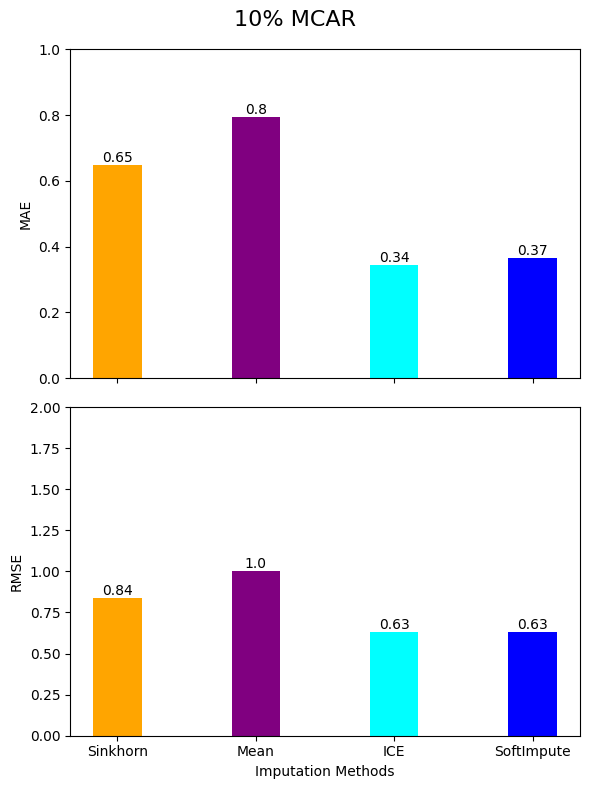

In [31]:

# Define values and categories
values_mae_mcar10 = [sk_mae_mcar10, mean_mae_mcar10, ice_mae_mcar10, soft_mae_mcar10]
values_rmse_mcar10 = [sk_rmse_mcar10, mean_rmse_mcar10, ice_rmse_mcar10, soft_rmse_mcar10]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('10% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar10, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar10, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


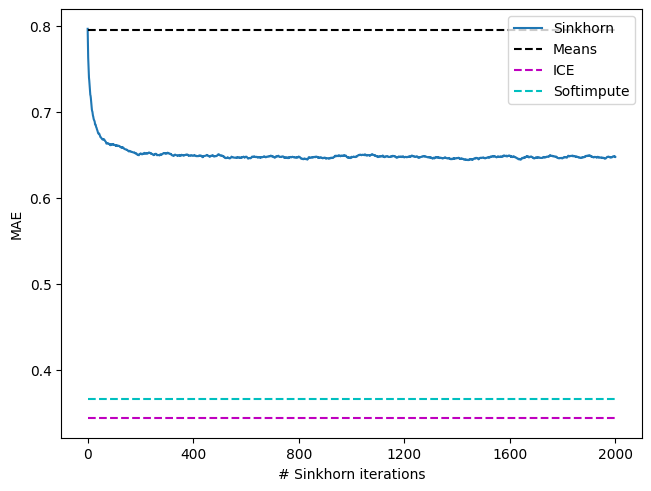

In [32]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes10mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes10mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar10, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar10, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar10, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

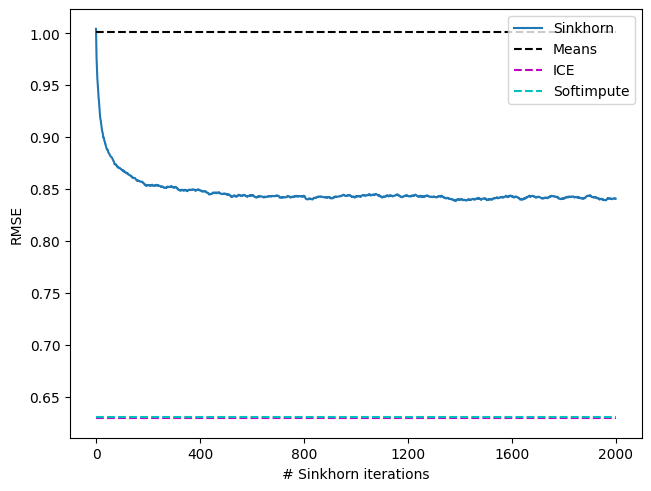

In [33]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses10mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses10mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar10, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar10, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar10, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**15% MCAR**

In [34]:
#sinkhorn
n_mcar15, d_mcar15 = data_mcar15.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar15 = pick_epsilon(data_mcar15)

print(epsilon_mcar15)

sk_imputer_mcar15 = SinkhornImputation(eps=epsilon_mcar15, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar15, sk_maes15mcar, sk_rmses15mcar = sk_imputer_mcar15.fit_transform(data_mcar15, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar15_numpy = sk_imp_mcar15.detach().cpu().numpy()

sk_mae_mcar15 = MAE(sk_imp_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
sk_rmse_mcar15 = RMSE(sk_imp_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(sk_mae_mcar15,sk_rmse_mcar15)

INFO:root:batchsize = 128, epsilon = 2.0318
INFO:root:Iteration 0:	 Loss: 10.3037	 Validation MAE: 0.7989	RMSE: 1.0136


2.0317526715674847


INFO:root:Iteration 500:	 Loss: 11.0605	 Validation MAE: 0.6456	RMSE: 0.8519
INFO:root:Iteration 1000:	 Loss: 9.4799	 Validation MAE: 0.6461	RMSE: 0.8502
INFO:root:Iteration 1500:	 Loss: 11.3605	 Validation MAE: 0.6439	RMSE: 0.8474


0.6457133393026994 0.8517726375453069


In [35]:
#mean
#using numpy version of data
mean_imp_mcar15 = SimpleImputer().fit_transform(data_mcar15_numpy)
mean_mae_mcar15 = MAE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
mean_rmse_mcar15= RMSE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(mean_mae_mcar15, mean_rmse_mcar15)

#ICE
ice_imp_mcar15 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar15_numpy)
ice_mae_mcar15 = MAE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
ice_rmse_mcar15 = RMSE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(ice_mae_mcar15,ice_rmse_mcar15)

#SoftImpute
cv_error_mcar15, grid_lambda_mcar15 = cv_softimpute(data_mcar15_numpy, grid_len=15)
lbda_mcar15 = grid_lambda_mcar15[np.argmin(cv_error_mcar15)]
soft_imp_mcar15 = softimpute((data_mcar15_numpy), lbda_mcar15)[1]

soft_mae_mcar15 = MAE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
soft_rmse_mcar15 = RMSE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(soft_mae_mcar15,soft_rmse_mcar15)



0.7959685424611297 1.007015182272965
0.3663608332620057 0.6439640919018418
0.3925923019634043 0.6510030578461432


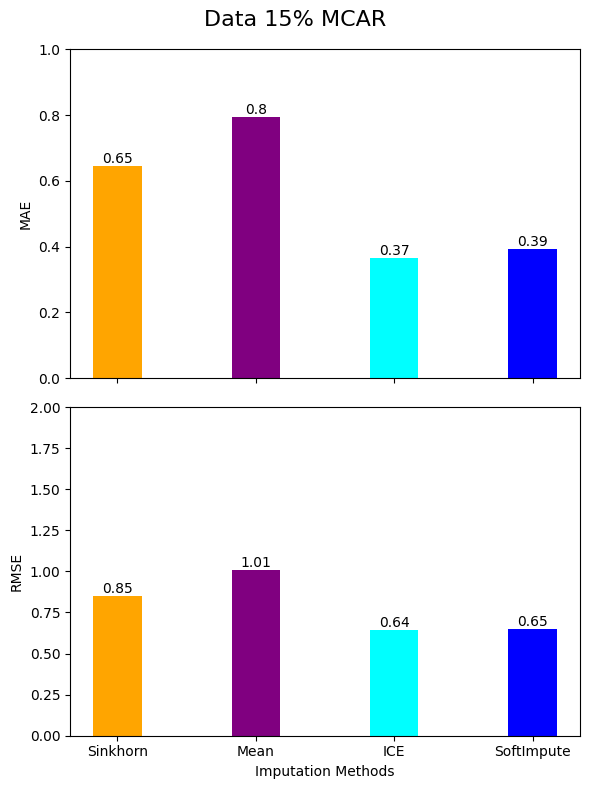

In [36]:

# Define values and categories
values_mae_mcar15 = [sk_mae_mcar15, mean_mae_mcar15, ice_mae_mcar15, soft_mae_mcar15]
values_rmse_mcar15 = [sk_rmse_mcar15, mean_rmse_mcar15, ice_rmse_mcar15, soft_rmse_mcar15]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 15% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar15, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar15, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


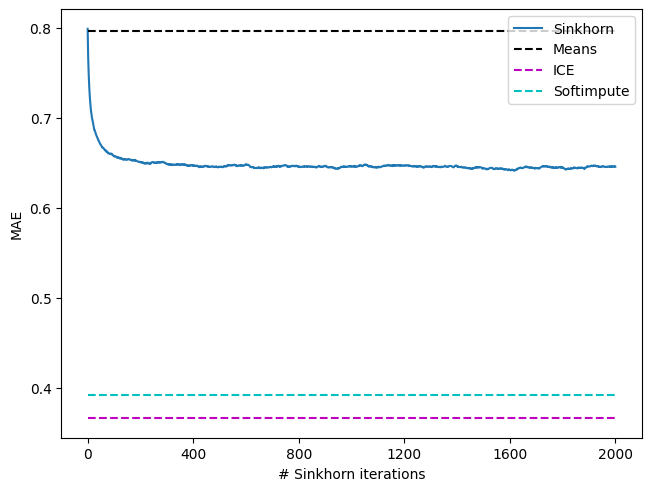

In [37]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes15mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes15mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar15, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar15, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar15, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

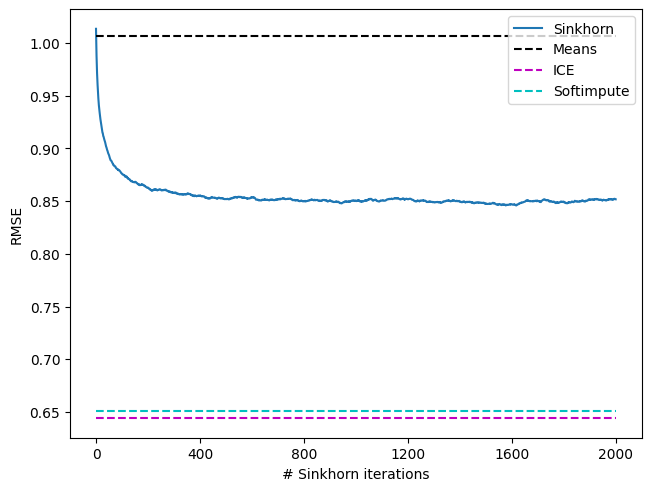

In [38]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses15mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses15mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar15, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar15, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar15, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**20% MCAR**

In [39]:
#sinkhorn
n_mcar20, d_mcar20 = data_mcar20.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar20 = pick_epsilon(data_mcar20)

print(epsilon_mcar20)

sk_imputer_mcar20 = SinkhornImputation(eps=epsilon_mcar20, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar20, sk_maes20mcar, sk_rmses20mcar = sk_imputer_mcar20.fit_transform(data_mcar20, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar20_numpy = sk_imp_mcar20.detach().cpu().numpy()

sk_mae_mcar20 = MAE(sk_imp_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
sk_rmse_mcar20 = RMSE(sk_imp_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(sk_mae_mcar20,sk_rmse_mcar20)

INFO:root:batchsize = 128, epsilon = 1.9133


INFO:root:Iteration 0:	 Loss: 10.5318	 Validation MAE: 0.7943	RMSE: 1.0116


1.9132789830409043


INFO:root:Iteration 500:	 Loss: 11.0386	 Validation MAE: 0.6481	RMSE: 0.8579
INFO:root:Iteration 1000:	 Loss: 11.0146	 Validation MAE: 0.6500	RMSE: 0.8577
INFO:root:Iteration 1500:	 Loss: 9.9274	 Validation MAE: 0.6487	RMSE: 0.8563


0.649846155970053 0.8572591632897777


In [40]:
#mean
#using numpy version of data
mean_imp_mcar20 = SimpleImputer().fit_transform(data_mcar20_numpy)
mean_mae_mcar20 = MAE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
mean_rmse_mcar20= RMSE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(mean_mae_mcar20, mean_rmse_mcar20)

#ICE
ice_imp_mcar20 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar20_numpy)
ice_mae_mcar20 = MAE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
ice_rmse_mcar20 = RMSE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(ice_mae_mcar20,ice_rmse_mcar20)

#SoftImpute
cv_error_mcar20, grid_lambda_mcar20 = cv_softimpute(data_mcar20_numpy, grid_len=15)
lbda_mcar20 = grid_lambda_mcar20[np.argmin(cv_error_mcar20)]
soft_imp_mcar20 = softimpute((data_mcar20_numpy), lbda_mcar20)[1]

soft_mae_mcar20 = MAE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
soft_rmse_mcar20 = RMSE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(soft_mae_mcar20,soft_rmse_mcar20)

0.7933877626272228 1.0055526470336633
0.401637040841643 0.673039627181898
0.4314421440260137 0.6792130614609776


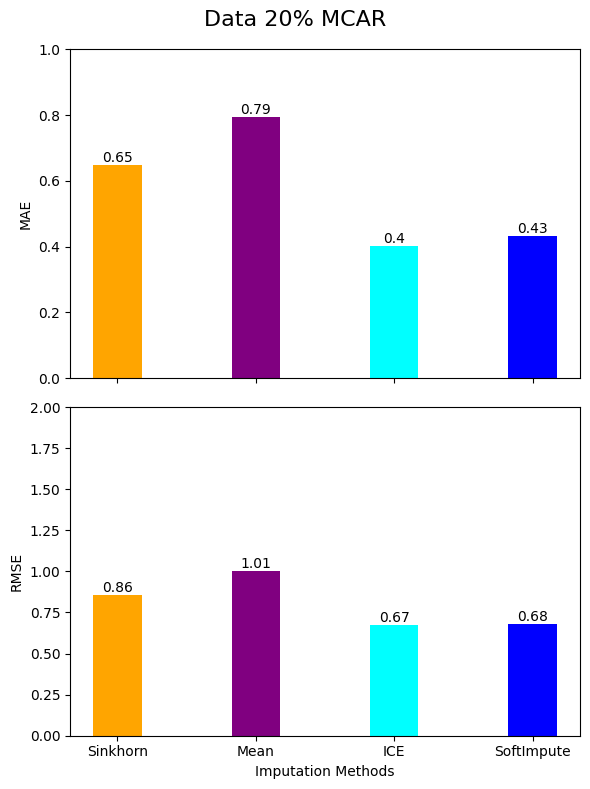

In [41]:

# Define values and categories
values_mae_mcar20 = [sk_mae_mcar20, mean_mae_mcar20, ice_mae_mcar20, soft_mae_mcar20]
values_rmse_mcar20 = [sk_rmse_mcar20, mean_rmse_mcar20, ice_rmse_mcar20, soft_rmse_mcar20]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 20% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar20, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar20, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


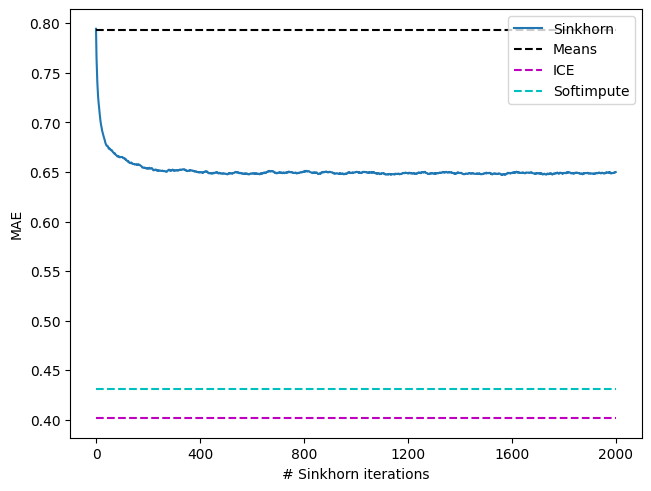

In [42]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes20mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes20mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar20, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar20, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar20, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

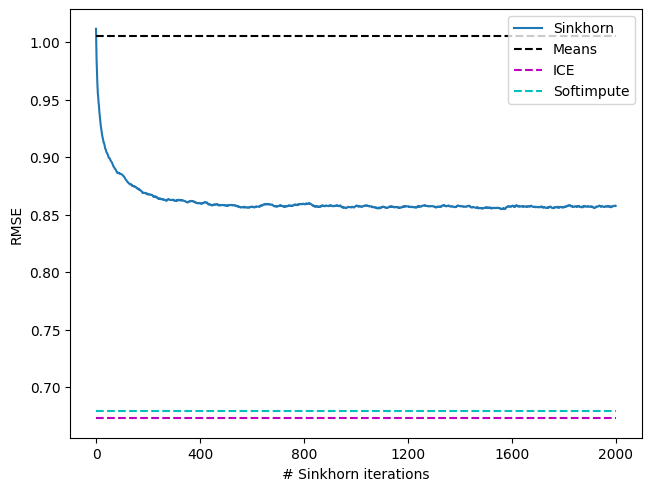

In [43]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses20mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses20mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar20, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar20, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar20, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**25% MCAR**

In [44]:
#sinkhorn
n_mcar25, d_mcar25 = data_mcar25.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(data_mcar25)

print(epsilon_mcar25)

sk_imputer_mcar25 = SinkhornImputation(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar25, sk_maes25mcar, sk_rmses25mcar = sk_imputer_mcar25.fit_transform(data_mcar25, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar25_numpy = sk_imp_mcar25.detach().cpu().numpy()

sk_mae_mcar25 = MAE(sk_imp_mcar25_numpy,ground_truth_numpy ,mask_mcar25)
sk_rmse_mcar25 = RMSE(sk_imp_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(sk_mae_mcar25,sk_rmse_mcar25)

INFO:root:batchsize = 128, epsilon = 1.7846
INFO:root:Iteration 0:	 Loss: 10.1188	 Validation MAE: 0.7924	RMSE: 1.0055


1.784624684353004


INFO:root:Iteration 500:	 Loss: 12.0845	 Validation MAE: 0.6508	RMSE: 0.8692
INFO:root:Iteration 1000:	 Loss: 10.1279	 Validation MAE: 0.6522	RMSE: 0.8673
INFO:root:Iteration 1500:	 Loss: 11.6133	 Validation MAE: 0.6505	RMSE: 0.8661


0.6510722300888822 0.8663625341259267


In [45]:
#mean
#using numpy version of data
mean_imp_mcar25 = SimpleImputer().fit_transform(data_mcar25_numpy)
mean_mae_mcar25 = MAE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
mean_rmse_mcar25= RMSE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(mean_mae_mcar25, mean_rmse_mcar25)

#ICE
ice_imp_mcar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar25_numpy)
ice_mae_mcar25 = MAE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
ice_rmse_mcar25 = RMSE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(ice_mae_mcar25,ice_rmse_mcar25)

#SoftImpute
cv_error_mcar25, grid_lambda_mcar25 = cv_softimpute(data_mcar25_numpy, grid_len=15)
lbda_mcar25 = grid_lambda_mcar25[np.argmin(cv_error_mcar25)]
soft_imp_mcar25 = softimpute((data_mcar25_numpy), lbda_mcar25)[1]

soft_mae_mcar25 = MAE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
soft_rmse_mcar25 = RMSE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(soft_mae_mcar25,soft_rmse_mcar25)

0.7912027822743986 1.0012992611963751
0.44112076200450767 0.7148366787777368
0.4678968781025373 0.7142939761141108


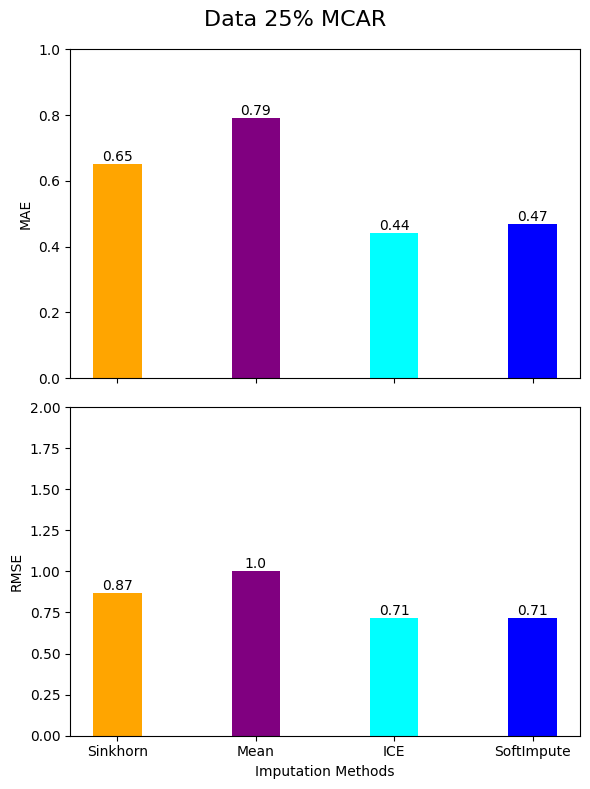

In [46]:

# Define values and categories
values_mae_mcar25 = [sk_mae_mcar25, mean_mae_mcar25, ice_mae_mcar25, soft_mae_mcar25]
values_rmse_mcar25 = [sk_rmse_mcar25, mean_rmse_mcar25, ice_rmse_mcar25, soft_rmse_mcar25]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


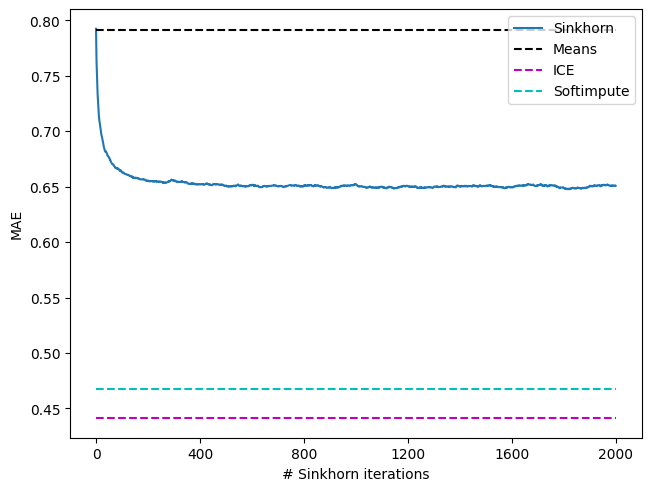

In [47]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes25mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes25mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar25, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar25, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar25, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

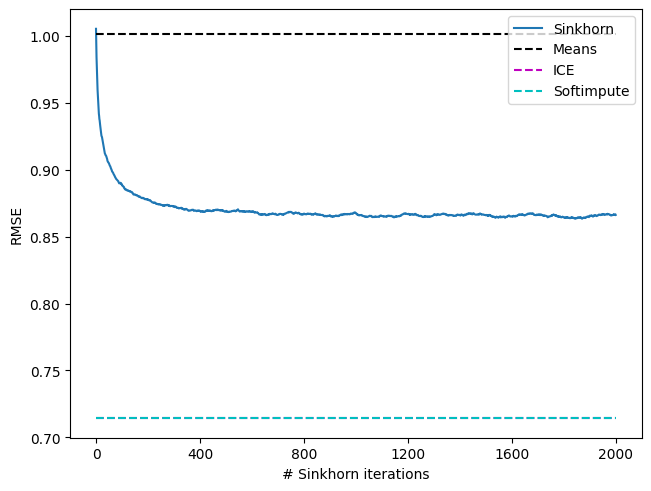

In [48]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses25mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses25mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar25, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar25, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar25, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**30% MCAR**

In [49]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(data_mcar30)
print(epsilon_mcar30)

sk_imputer_mcar30 = SinkhornImputation(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:batchsize = 128, epsilon = 1.6520
INFO:root:Iteration 0:	 Loss: 10.5946	 Validation MAE: 0.7987	RMSE: 1.0197


1.6520451297625833


INFO:root:Iteration 500:	 Loss: 10.0251	 Validation MAE: 0.6615	RMSE: 0.8958
INFO:root:Iteration 1000:	 Loss: 9.2650	 Validation MAE: 0.6615	RMSE: 0.8932
INFO:root:Iteration 1500:	 Loss: 10.3741	 Validation MAE: 0.6597	RMSE: 0.8928


0.6597045818608644 0.8908867780242034


In [50]:
#mean
#using numpy version of data
mean_imp_mcar30 = SimpleImputer().fit_transform(data_mcar30_numpy)
mean_mae_mcar30 = MAE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
mean_rmse_mcar30= RMSE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(mean_mae_mcar30, mean_rmse_mcar30)

#ICE
ice_imp_mcar30 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar30_numpy)
ice_mae_mcar30 = MAE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
ice_rmse_mcar30 = RMSE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(ice_mae_mcar30,ice_rmse_mcar30)

#SoftImpute
cv_error_mcar30, grid_lambda_mcar30 = cv_softimpute(data_mcar30_numpy, grid_len=15)
lbda_mcar30 = grid_lambda_mcar30[np.argmin(cv_error_mcar30)]
soft_imp_mcar30 = softimpute((data_mcar30_numpy), lbda_mcar30)[1]

soft_mae_mcar30 = MAE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
soft_rmse_mcar30 = RMSE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(soft_mae_mcar30,soft_rmse_mcar30)

0.7968492360936335 1.015155477668222
0.49783860649963896 0.7852954098066728
0.4945541467458493 0.746863285188395


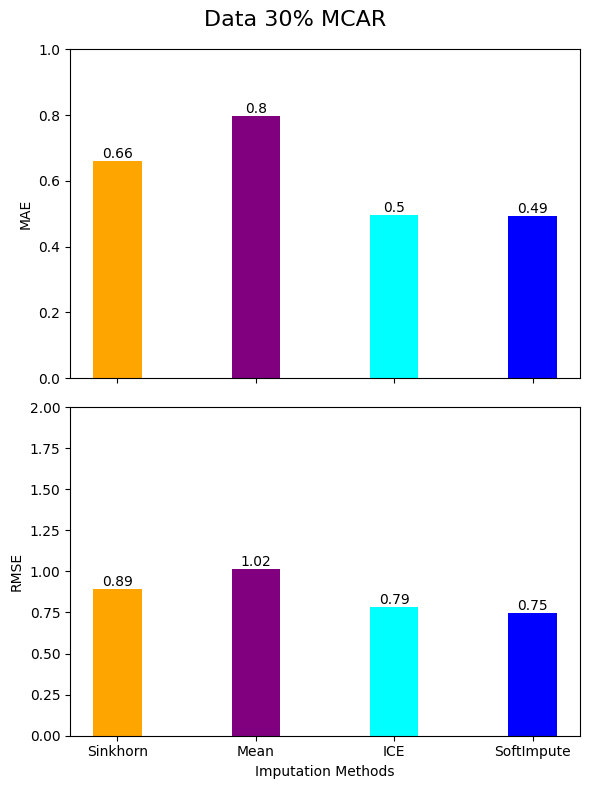

In [51]:

# Define values and categories
values_mae_mcar30 = [sk_mae_mcar30, mean_mae_mcar30, ice_mae_mcar30, soft_mae_mcar30]
values_rmse_mcar30 = [sk_rmse_mcar30, mean_rmse_mcar30, ice_rmse_mcar30, soft_rmse_mcar30]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 30% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar30, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar30, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


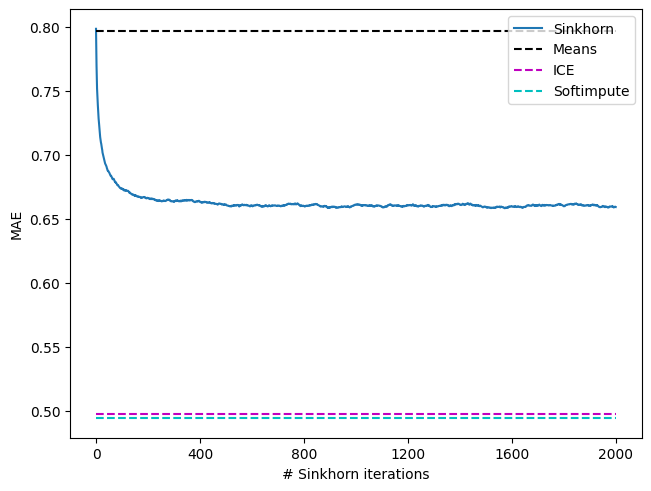

In [52]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes30mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes30mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar30, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar30, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar30, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

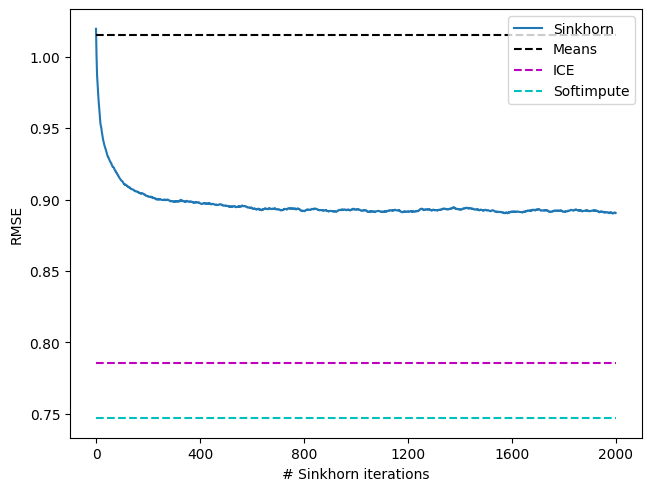

In [53]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses30mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses30mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar30, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar30, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar30, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**35% MCAR**

In [54]:
#sinkhorn
n_mcar35, d_mcar35 = data_mcar35.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar35 = pick_epsilon(data_mcar35)

print(epsilon_mcar35)

sk_imputer_mcar35 = SinkhornImputation(eps=epsilon_mcar35, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar35, sk_maes35mcar, sk_rmses35mcar = sk_imputer_mcar35.fit_transform(data_mcar35, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar35_numpy = sk_imp_mcar35.detach().cpu().numpy()

sk_mae_mcar35 = MAE(sk_imp_mcar35_numpy,ground_truth_numpy ,mask_mcar35)
sk_rmse_mcar35 = RMSE(sk_imp_mcar35_numpy, ground_truth_numpy,mask_mcar35)
print(sk_mae_mcar35,sk_rmse_mcar35)

INFO:root:batchsize = 128, epsilon = 1.5163
INFO:root:Iteration 0:	 Loss: 10.4007	 Validation MAE: 0.8017	RMSE: 1.0225


1.5163330512295157


INFO:root:Iteration 500:	 Loss: 10.0727	 Validation MAE: 0.6704	RMSE: 0.9114
INFO:root:Iteration 1000:	 Loss: 9.5488	 Validation MAE: 0.6705	RMSE: 0.9116
INFO:root:Iteration 1500:	 Loss: 10.5661	 Validation MAE: 0.6723	RMSE: 0.9130


0.6701003854893469 0.9118082960549247


In [55]:
#mean
#using numpy version of data
mean_imp_mcar35 = SimpleImputer().fit_transform(data_mcar35_numpy)
mean_mae_mcar35 = MAE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
mean_rmse_mcar35 = RMSE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(mean_mae_mcar35, mean_rmse_mcar35)

#ICE
ice_imp_mcar35 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar35_numpy)
ice_mae_mcar35 = MAE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
ice_rmse_mcar35 = RMSE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(ice_mae_mcar35,ice_rmse_mcar35)

#SoftImpute
cv_error_mcar35, grid_lambda_mcar35 = cv_softimpute(data_mcar35_numpy, grid_len=15)
lbda_mcar35 = grid_lambda_mcar35[np.argmin(cv_error_mcar35)]
soft_imp_mcar35 = softimpute((data_mcar35_numpy), lbda_mcar35)[1]

soft_mae_mcar35 = MAE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
soft_rmse_mcar35 = RMSE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(soft_mae_mcar35,soft_rmse_mcar35)

0.7995230788489436 1.0175014222155785
0.5411648607794954 0.818766974732253
0.5210309014895511 0.7763480580947173


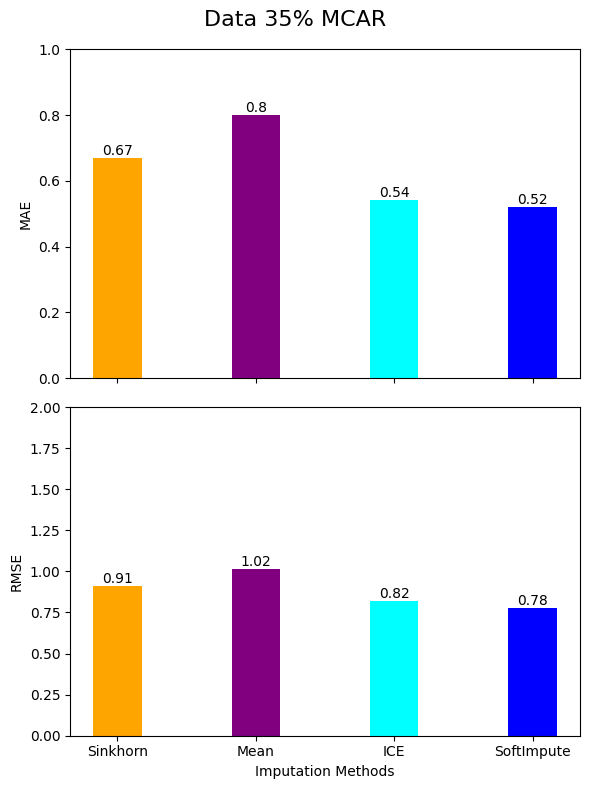

In [56]:

# Define values and categories
values_mae_mcar35 = [sk_mae_mcar35, mean_mae_mcar35, ice_mae_mcar35, soft_mae_mcar35]
values_rmse_mcar35 = [sk_rmse_mcar35, mean_rmse_mcar35, ice_rmse_mcar35, soft_rmse_mcar35]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 35% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


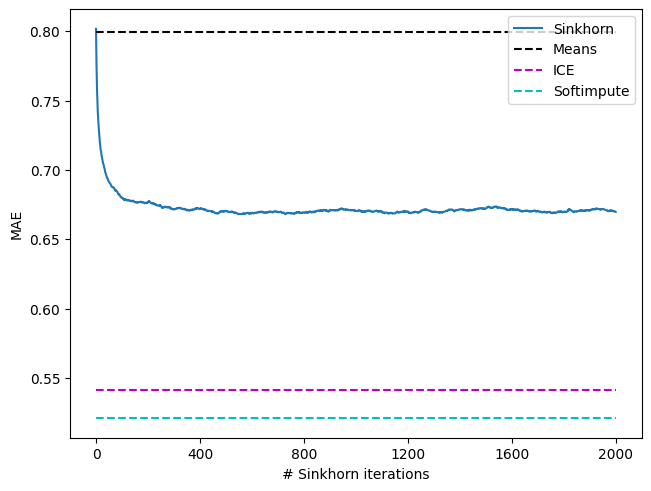

In [57]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes35mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes35mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar35, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar35, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar35, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

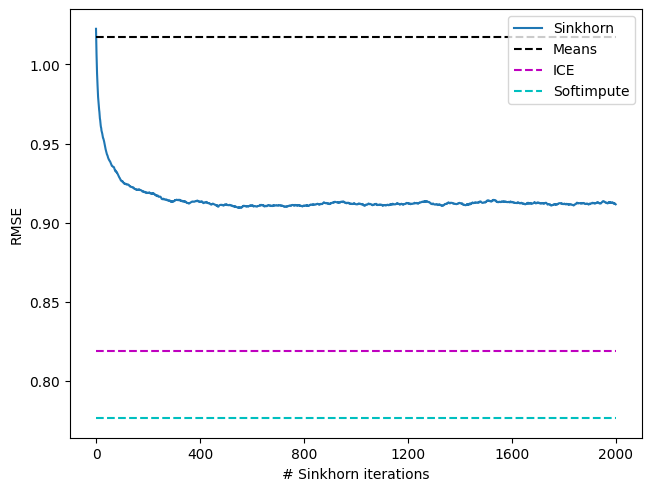

In [58]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses35mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses35mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar35, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar35, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar35, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**40% MCAR**

In [59]:
#sinkhorn
n_mcar40, d_mcar40 = data_mcar40.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar40 = pick_epsilon(data_mcar40)

print(epsilon_mcar40)

sk_imputer_mcar40 = SinkhornImputation(eps=epsilon_mcar40, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar40, sk_maes40mcar, sk_rmses40mcar = sk_imputer_mcar40.fit_transform(data_mcar40, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar40_numpy = sk_imp_mcar40.detach().cpu().numpy()

sk_mae_mcar40 = MAE(sk_imp_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
sk_rmse_mcar40 = RMSE(sk_imp_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(sk_mae_mcar40,sk_rmse_mcar40)

INFO:root:batchsize = 128, epsilon = 1.3885
INFO:root:Iteration 0:	 Loss: 9.5971	 Validation MAE: 0.8006	RMSE: 1.0249


1.3885000004369026


INFO:root:Iteration 500:	 Loss: 10.1513	 Validation MAE: 0.6724	RMSE: 0.9220
INFO:root:Iteration 1000:	 Loss: 9.4772	 Validation MAE: 0.6701	RMSE: 0.9190
INFO:root:Iteration 1500:	 Loss: 10.6510	 Validation MAE: 0.6703	RMSE: 0.9189


0.6690088203142897 0.9212947542117675


In [60]:
#mean
#using numpy version of data
mean_imp_mcar40 = SimpleImputer().fit_transform(data_mcar40_numpy)
mean_mae_mcar40 = MAE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
mean_rmse_mcar40= RMSE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(mean_mae_mcar40, mean_rmse_mcar40)

#ICE
ice_imp_mcar40 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar40_numpy)
ice_mae_mcar40 = MAE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
ice_rmse_mcar40 = RMSE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(ice_mae_mcar40,ice_rmse_mcar40)

#SoftImpute
cv_error_mcar40, grid_lambda_mcar40 = cv_softimpute(data_mcar40_numpy, grid_len=15)
lbda_mcar40 = grid_lambda_mcar40[np.argmin(cv_error_mcar40)]
soft_imp_mcar40 = softimpute((data_mcar40_numpy), lbda_mcar40)[1]

soft_mae_mcar40 = MAE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
soft_rmse_mcar40 = RMSE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(soft_mae_mcar40,soft_rmse_mcar40)

0.7990669176526305 1.018975128424428
0.5723469178559366 0.8515457034008068
0.5432316958817739 0.7965727785550101


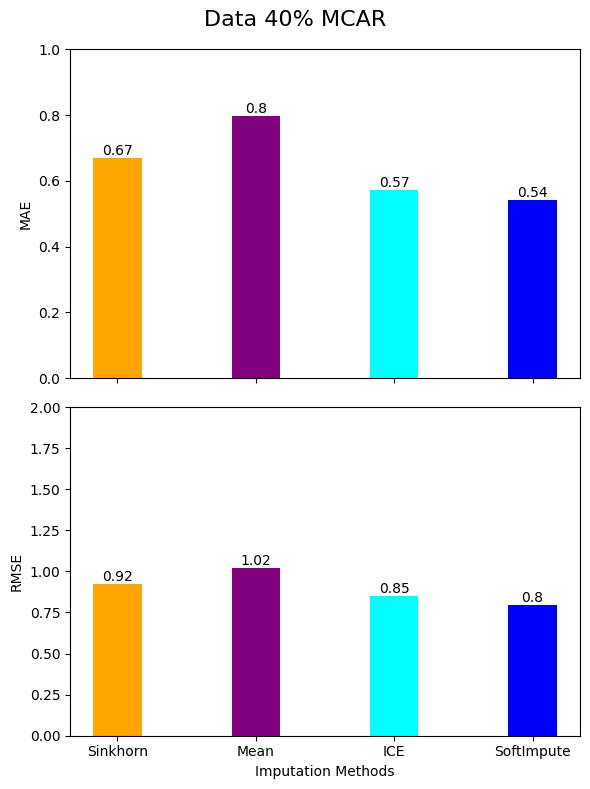

In [61]:

# Define values and categories
values_mae_mcar40 = [sk_mae_mcar40, mean_mae_mcar40, ice_mae_mcar40, soft_mae_mcar40]
values_rmse_mcar40 = [sk_rmse_mcar40, mean_rmse_mcar40, ice_rmse_mcar40, soft_rmse_mcar40]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 40% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar40, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar40, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


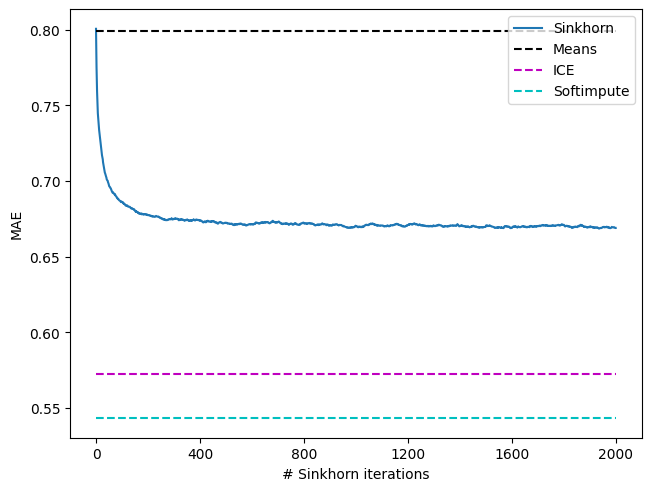

In [62]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes40mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes40mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar40, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar40, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar40, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

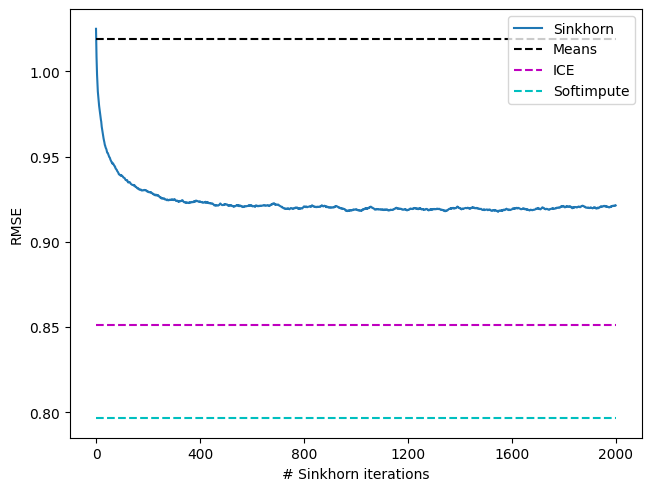

In [63]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses40mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses40mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar40, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar40, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar40, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**45% MCAR**

In [64]:
#sinkhorn
n_mcar45, d_mcar45 = data_mcar45.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar45 = pick_epsilon(data_mcar45)

print(epsilon_mcar45)

sk_imputer_mcar45 = SinkhornImputation(eps=epsilon_mcar45, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar45, sk_maes45mcar, sk_rmses45mcar = sk_imputer_mcar45.fit_transform(data_mcar45, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar45_numpy = sk_imp_mcar45.detach().cpu().numpy()

sk_mae_mcar45 = MAE(sk_imp_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
sk_rmse_mcar45 = RMSE(sk_imp_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(sk_mae_mcar45,sk_rmse_mcar45)

INFO:root:batchsize = 128, epsilon = 1.2519
INFO:root:Iteration 0:	 Loss: 9.0890	 Validation MAE: 0.7978	RMSE: 1.0189


1.251855995620403


INFO:root:Iteration 500:	 Loss: 8.9382	 Validation MAE: 0.6781	RMSE: 0.9409
INFO:root:Iteration 1000:	 Loss: 7.9327	 Validation MAE: 0.6797	RMSE: 0.9434
INFO:root:Iteration 1500:	 Loss: 9.5123	 Validation MAE: 0.6805	RMSE: 0.9465


0.6820067750226964 0.9498377230249213


In [65]:
#mean
#using numpy version of data
mean_imp_mcar45 = SimpleImputer().fit_transform(data_mcar45_numpy)
mean_mae_mcar45 = MAE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
mean_rmse_mcar45= RMSE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(mean_mae_mcar45, mean_rmse_mcar45)

#ICE
ice_imp_mcar45 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar45_numpy)
ice_mae_mcar45 = MAE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
ice_rmse_mcar45 = RMSE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(ice_mae_mcar45,ice_rmse_mcar45)

#SoftImpute
cv_error_mcar45, grid_lambda_mcar45 = cv_softimpute(data_mcar45_numpy, grid_len=15)
lbda_mcar45 = grid_lambda_mcar45[np.argmin(cv_error_mcar45)]
soft_imp_mcar45 = softimpute((data_mcar45_numpy), lbda_mcar45)[1]

soft_mae_mcar45 = MAE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
soft_rmse_mcar45 = RMSE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(soft_mae_mcar45,soft_rmse_mcar45)

0.795852996963783 1.0139581601199965
0.5861196533686395 0.8487381280545484
0.5712816923852198 0.8172951810405036


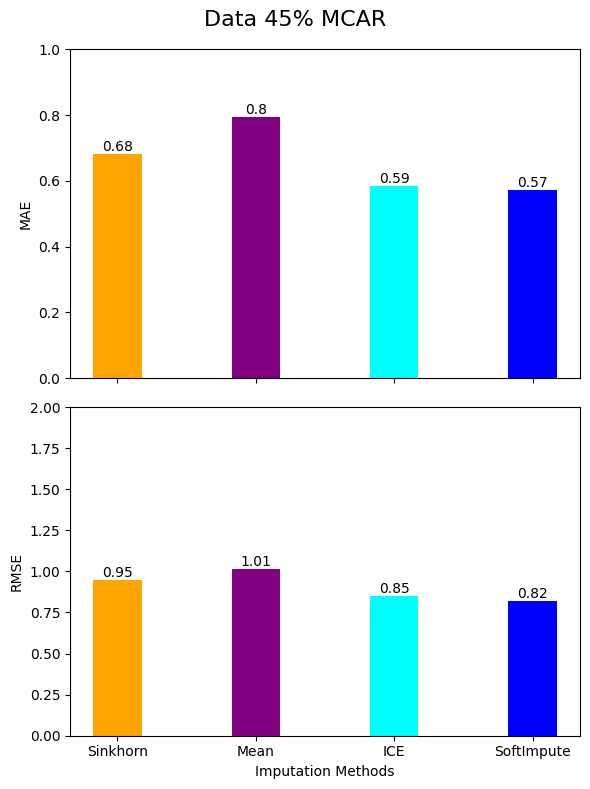

In [66]:

# Define values and categories
values_mae_mcar45 = [sk_mae_mcar45, mean_mae_mcar45, ice_mae_mcar45, soft_mae_mcar45]
values_rmse_mcar45 = [sk_rmse_mcar45, mean_rmse_mcar45, ice_rmse_mcar45, soft_rmse_mcar45]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 45% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar45, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar45, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


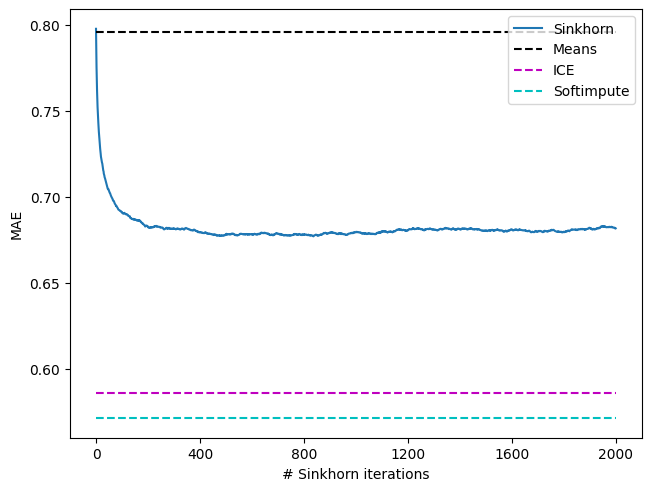

In [67]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes45mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes45mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar45, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar45, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar45, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

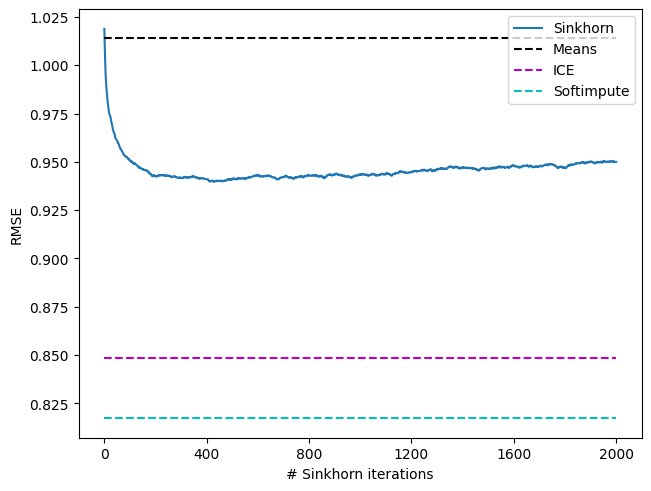

In [68]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses45mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses45mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar45, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar45, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar45, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**50% MCAR**

In [69]:
#sinkhorn
n_mcar50, d_mcar50 = data_mcar50.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar50 = pick_epsilon(data_mcar50)

print(epsilon_mcar50)

sk_imputer_mcar50 = SinkhornImputation(eps=epsilon_mcar50, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar50, sk_maes50mcar, sk_rmses50mcar = sk_imputer_mcar50.fit_transform(data_mcar50, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar50_numpy = sk_imp_mcar50.detach().cpu().numpy()

sk_mae_mcar50 = MAE(sk_imp_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
sk_rmse_mcar50 = RMSE(sk_imp_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(sk_mae_mcar50,sk_rmse_mcar50)

INFO:root:batchsize = 128, epsilon = 1.1282
INFO:root:Iteration 0:	 Loss: 8.9975	 Validation MAE: 0.7957	RMSE: 1.0165


1.1282035070601624


INFO:root:Iteration 500:	 Loss: 7.8337	 Validation MAE: 0.6824	RMSE: 0.9566
INFO:root:Iteration 1000:	 Loss: 7.2148	 Validation MAE: 0.6836	RMSE: 0.9629
INFO:root:Iteration 1500:	 Loss: 7.1410	 Validation MAE: 0.6847	RMSE: 0.9646


0.686897600739139 0.9689845899932001


In [70]:
#mean
#using numpy version of data
mean_imp_mcar50 = SimpleImputer().fit_transform(data_mcar50_numpy)
mean_mae_mcar50 = MAE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
mean_rmse_mcar50= RMSE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(mean_mae_mcar50, mean_rmse_mcar50)

#ICE
ice_imp_mcar50 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar50_numpy)
ice_mae_mcar50 = MAE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
ice_rmse_mcar50 = RMSE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(ice_mae_mcar50,ice_rmse_mcar50)

#SoftImpute
cv_error_mcar50, grid_lambda_mcar50 = cv_softimpute(data_mcar50_numpy, grid_len=15)
lbda_mcar50 = grid_lambda_mcar50[np.argmin(cv_error_mcar50)]
soft_imp_mcar50 = softimpute((data_mcar50_numpy), lbda_mcar50)[1]

soft_mae_mcar50 = MAE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
soft_rmse_mcar50 = RMSE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(soft_mae_mcar50,soft_rmse_mcar50)

0.794037169955174 1.0126022710931568
0.6228477554002619 0.8746984351215696
0.5974075169037528 0.8409599525526994


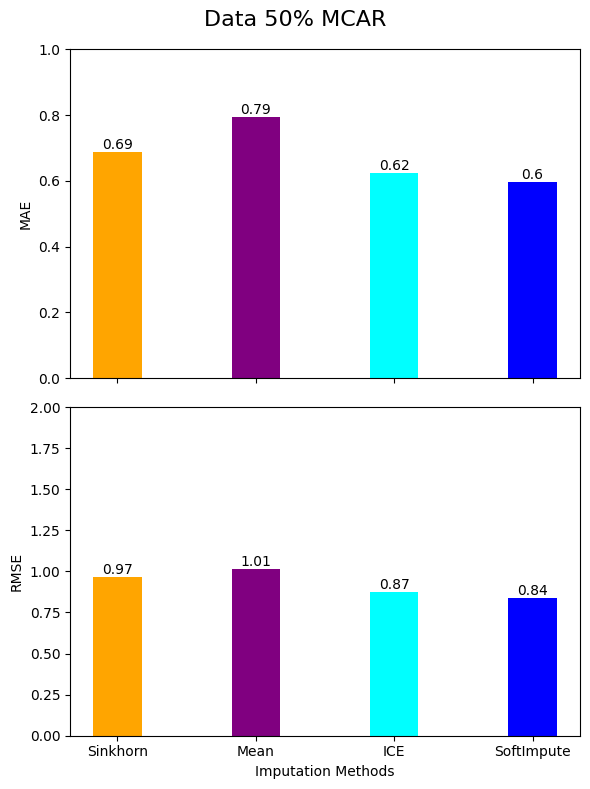

In [71]:

# Define values and categories
values_mae_mcar50 = [sk_mae_mcar50, mean_mae_mcar50, ice_mae_mcar50, soft_mae_mcar50]
values_rmse_mcar50 = [sk_rmse_mcar50, mean_rmse_mcar50, ice_rmse_mcar50, soft_rmse_mcar50]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 50% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar50, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar50, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


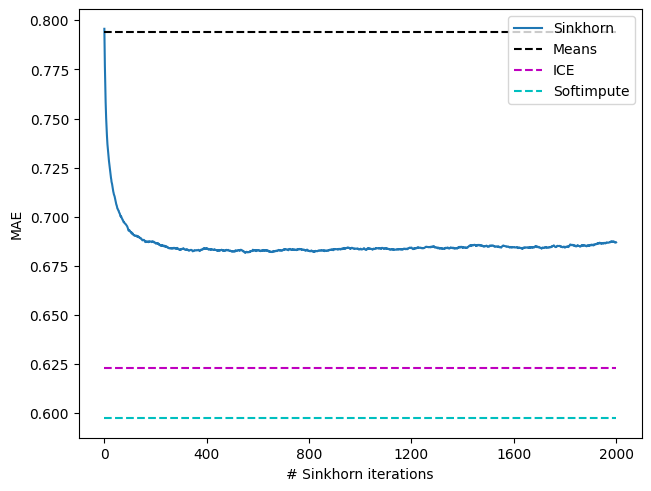

In [72]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

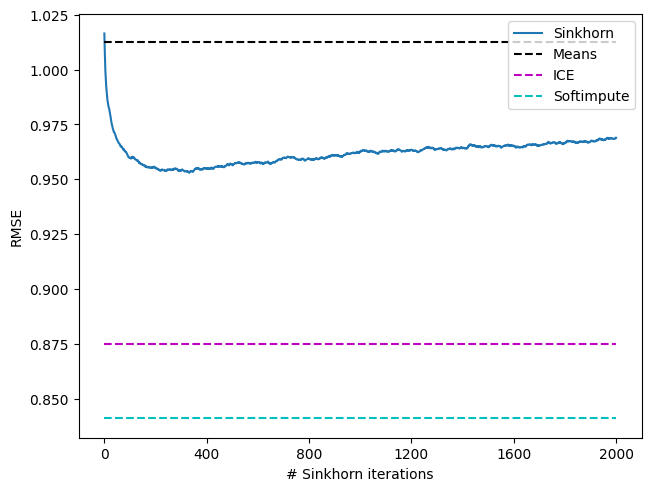

In [73]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

60% MCAR

In [74]:
#sinkhorn
n_mcar60, d_mcar60 = data_mcar60.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar60 = pick_epsilon(data_mcar60)

print(epsilon_mcar60)

sk_imputer_mcar60 = SinkhornImputation(eps=epsilon_mcar60, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar60, sk_maes60mcar, sk_rmses60mcar = sk_imputer_mcar60.fit_transform(data_mcar60, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar60_numpy = sk_imp_mcar60.detach().cpu().numpy()

sk_mae_mcar60 = MAE(sk_imp_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
sk_rmse_mcar60 = RMSE(sk_imp_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(sk_mae_mcar60,sk_rmse_mcar60)

INFO:root:batchsize = 128, epsilon = 0.8911
INFO:root:Iteration 0:	 Loss: 8.1877	 Validation MAE: 0.7966	RMSE: 1.0147


0.8910568140800801


INFO:root:Iteration 500:	 Loss: 6.4939	 Validation MAE: 0.6989	RMSE: 0.9878
INFO:root:Iteration 1000:	 Loss: 6.7198	 Validation MAE: 0.7045	RMSE: 1.0011
INFO:root:Iteration 1500:	 Loss: 5.6470	 Validation MAE: 0.7068	RMSE: 1.0099


0.708927578820487 1.0138187864225865


In [75]:
#mean
#using numpy version of data
mean_imp_mcar60 = SimpleImputer().fit_transform(data_mcar60_numpy)
mean_mae_mcar60 = MAE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
mean_rmse_mcar60= RMSE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(mean_mae_mcar60, mean_rmse_mcar60)

#ICE
ice_imp_mcar60 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar60_numpy)
ice_mae_mcar60 = MAE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
ice_rmse_mcar60 = RMSE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(ice_mae_mcar60,ice_rmse_mcar60)

#SoftImpute
cv_error_mcar60, grid_lambda_mcar60 = cv_softimpute(data_mcar60_numpy, grid_len=15)
lbda_mcar60 = grid_lambda_mcar60[np.argmin(cv_error_mcar60)]
soft_imp_mcar60 = softimpute((data_mcar60_numpy), lbda_mcar60)[1]

soft_mae_mcar60 = MAE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
soft_rmse_mcar60 = RMSE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(soft_mae_mcar60,soft_rmse_mcar60)

0.7925072974352514 1.009034748854904
0.6873419898502815 0.9328204814238437
0.6484786203141797 0.886095852367836


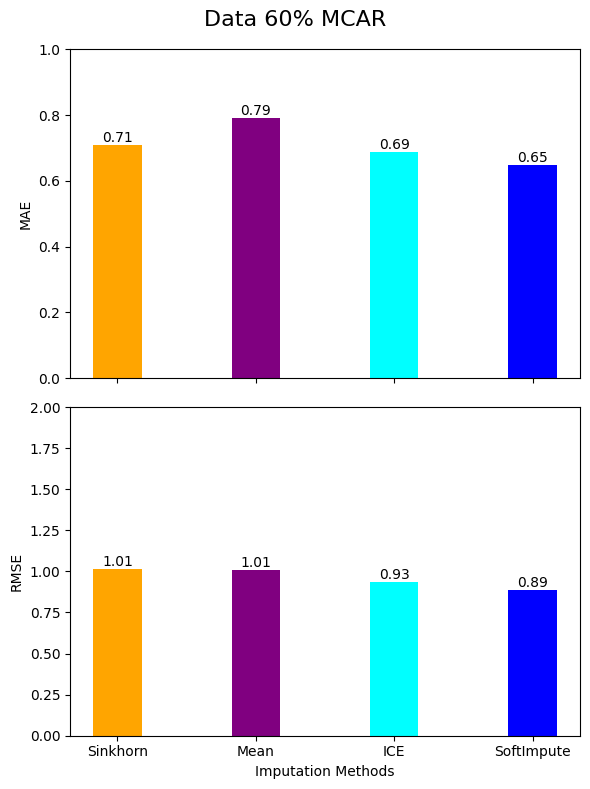

In [76]:

# Define values and categories
values_mae_mcar60 = [sk_mae_mcar60, mean_mae_mcar60, ice_mae_mcar60, soft_mae_mcar60]
values_rmse_mcar60 = [sk_rmse_mcar60, mean_rmse_mcar60, ice_rmse_mcar60, soft_rmse_mcar60]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 60% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar60, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar60, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


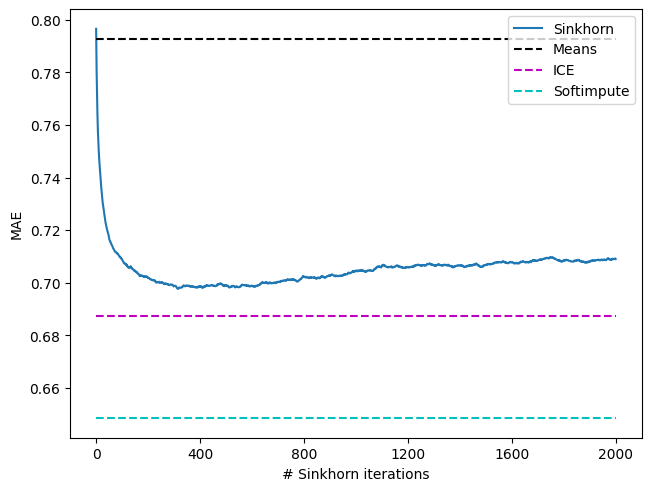

In [77]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

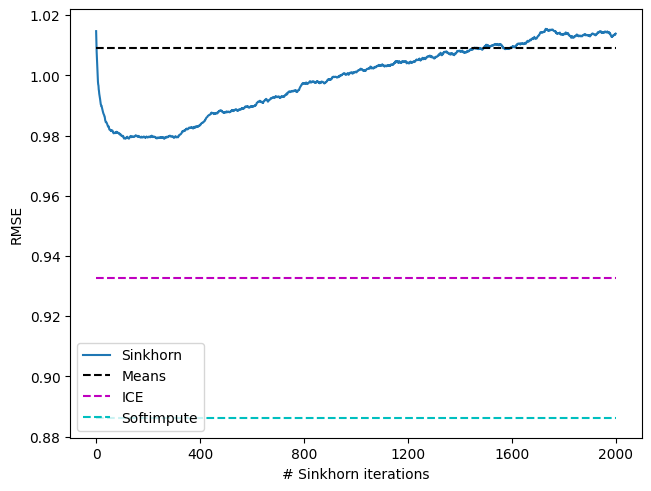

In [78]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

70% MCAR

In [79]:
#sinkhorn
n_mcar70, d_mcar70 = data_mcar70.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar70 = pick_epsilon(data_mcar70)

print(epsilon_mcar70)

sk_imputer_mcar70 = SinkhornImputation(eps=epsilon_mcar70, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar70, sk_maes70mcar, sk_rmses70mcar = sk_imputer_mcar70.fit_transform(data_mcar70, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar70_numpy = sk_imp_mcar70.detach().cpu().numpy()

sk_mae_mcar70 = MAE(sk_imp_mcar70_numpy,ground_truth_numpy ,mask_mcar70)
sk_rmse_mcar70 = RMSE(sk_imp_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(sk_mae_mcar70,sk_rmse_mcar70)

INFO:root:batchsize = 128, epsilon = 0.6665


0.6665194503360339


INFO:root:Iteration 0:	 Loss: 6.2618	 Validation MAE: 0.7956	RMSE: 1.0112
INFO:root:Iteration 500:	 Loss: 5.0346	 Validation MAE: 0.7140	RMSE: 1.0105
INFO:root:Iteration 1000:	 Loss: 5.5482	 Validation MAE: 0.7219	RMSE: 1.0295
INFO:root:Iteration 1500:	 Loss: 4.8442	 Validation MAE: 0.7263	RMSE: 1.0401


0.7309116820403422 1.0500317246172355


In [80]:
#mean
#using numpy version of data
mean_imp_mcar70 = SimpleImputer().fit_transform(data_mcar70_numpy)
mean_mae_mcar70 = MAE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
mean_rmse_mcar70= RMSE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(mean_mae_mcar70, mean_rmse_mcar70)

#ICE
ice_imp_mcar70 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar70_numpy)
ice_mae_mcar70 = MAE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
ice_rmse_mcar70 = RMSE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(ice_mae_mcar70,ice_rmse_mcar70)

#SoftImpute
cv_error_mcar70, grid_lambda_mcar70 = cv_softimpute(data_mcar70_numpy, grid_len=15)
lbda_mcar70 = grid_lambda_mcar70[np.argmin(cv_error_mcar70)]
soft_imp_mcar70 = softimpute((data_mcar70_numpy), lbda_mcar70)[1]

soft_mae_mcar70 = MAE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
soft_rmse_mcar70 = RMSE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(soft_mae_mcar70,soft_rmse_mcar70)

0.7924525829242329 1.0066028047838629
0.7420076026445083 0.9826790252418763
0.7194186531001857 0.9415491624043403


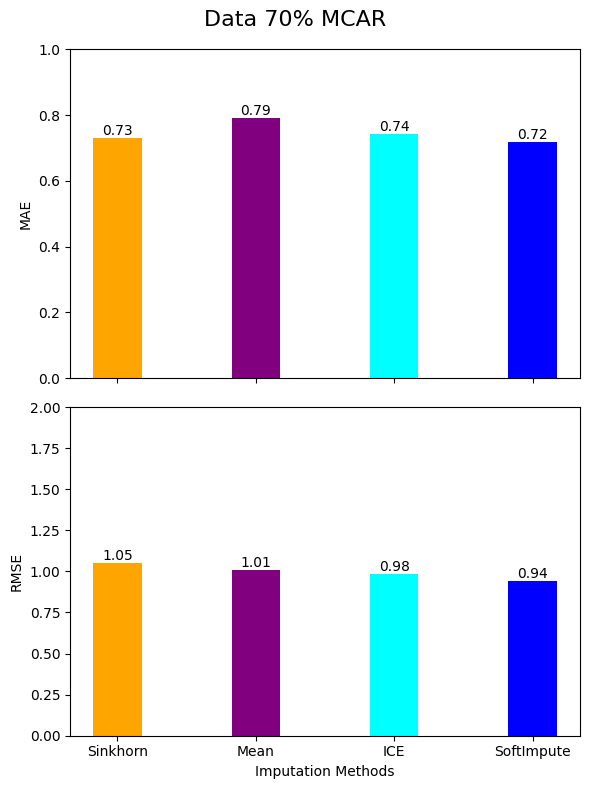

In [81]:

# Define values and categories
values_mae_mcar70 = [sk_mae_mcar70, mean_mae_mcar70, ice_mae_mcar70, soft_mae_mcar70]
values_rmse_mcar70 = [sk_rmse_mcar70, mean_rmse_mcar70, ice_rmse_mcar70, soft_rmse_mcar70]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 70% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar70, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar70, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


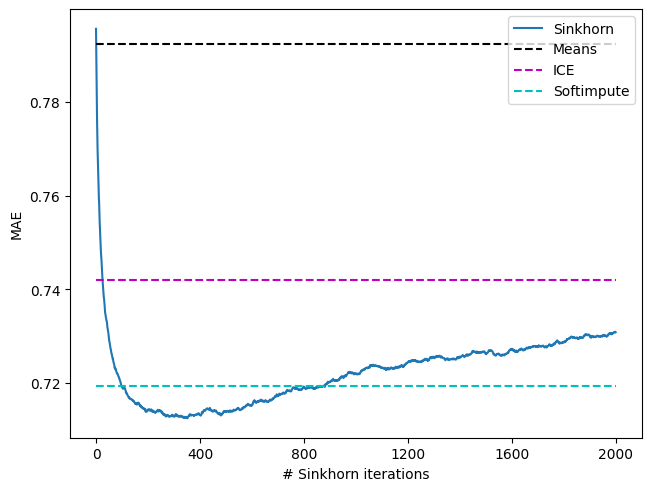

In [82]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

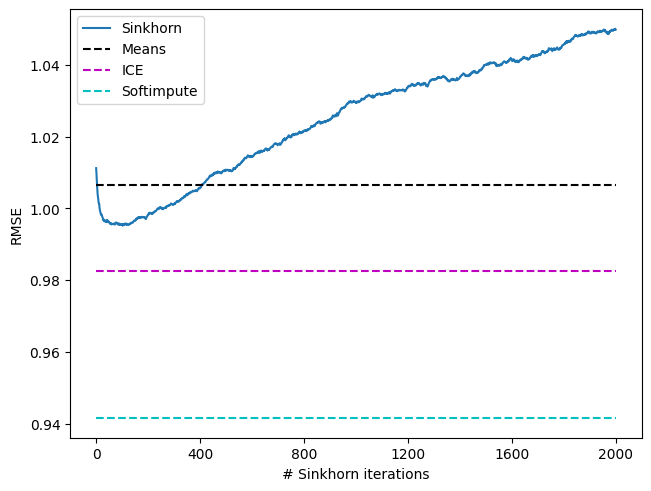

In [83]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

80% MCAR

In [84]:
#sinkhorn
n_mcar80, d_mcar80 = data_mcar80.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar80 = pick_epsilon(data_mcar80)

print(epsilon_mcar80)

sk_imputer_mcar80 = SinkhornImputation(eps=epsilon_mcar80, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar80, sk_maes80mcar, sk_rmses80mcar = sk_imputer_mcar80.fit_transform(data_mcar80, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar80_numpy = sk_imp_mcar80.detach().cpu().numpy()

sk_mae_mcar80 = MAE(sk_imp_mcar80_numpy,ground_truth_numpy ,mask_mcar80)
sk_rmse_mcar80 = RMSE(sk_imp_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(sk_mae_mcar80,sk_rmse_mcar80)

INFO:root:batchsize = 128, epsilon = 0.4248


0.4248159975115539


INFO:root:Iteration 0:	 Loss: 4.2495	 Validation MAE: 0.7882	RMSE: 1.0112
INFO:root:Iteration 500:	 Loss: 3.4614	 Validation MAE: 0.7354	RMSE: 1.0441
INFO:root:Iteration 1000:	 Loss: 3.1339	 Validation MAE: 0.7517	RMSE: 1.0796
INFO:root:Iteration 1500:	 Loss: 3.4148	 Validation MAE: 0.7627	RMSE: 1.1037


0.7704881451888882 1.1205731366637242


In [85]:
#mean
#using numpy version of data
mean_imp_mcar80 = SimpleImputer().fit_transform(data_mcar80_numpy)
mean_mae_mcar80 = MAE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
mean_rmse_mcar80= RMSE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(mean_mae_mcar80, mean_rmse_mcar80)

#ICE
ice_imp_mcar80 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar80_numpy)
ice_mae_mcar80 = MAE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
ice_rmse_mcar80 = RMSE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(ice_mae_mcar80,ice_rmse_mcar80)

#SoftImpute
cv_error_mcar80, grid_lambda_mcar80 = cv_softimpute(data_mcar80_numpy, grid_len=15)
lbda_mcar80 = grid_lambda_mcar80[np.argmin(cv_error_mcar80)]
soft_imp_mcar80 = softimpute((data_mcar80_numpy), lbda_mcar80)[1]

soft_mae_mcar80 = MAE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
soft_rmse_mcar80 = RMSE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(soft_mae_mcar80,soft_rmse_mcar80)

0.7869172644359032 1.007522074807293
0.8000366170704762 1.0392845712831142
0.7639595918037262 0.9806822777454395


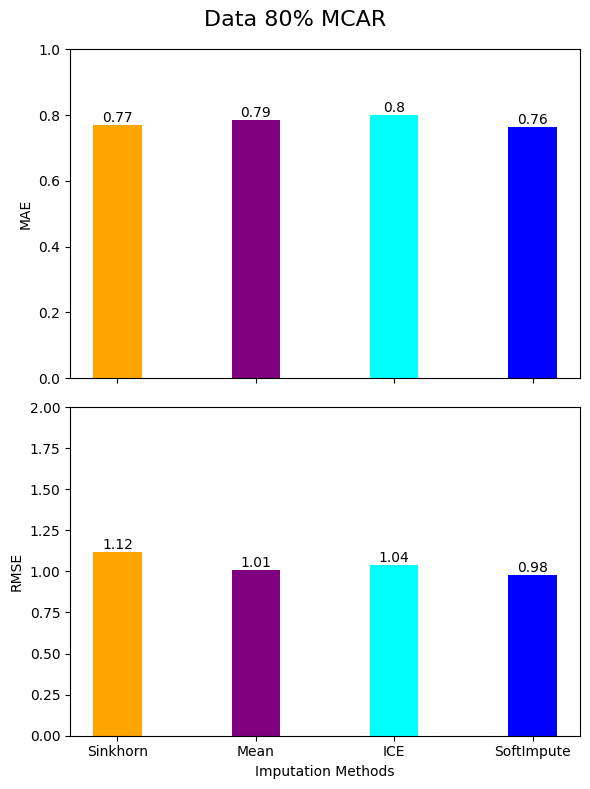

In [86]:

# Define values and categories
values_mae_mcar80 = [sk_mae_mcar80, mean_mae_mcar80, ice_mae_mcar80, soft_mae_mcar80]
values_rmse_mcar80 = [sk_rmse_mcar80, mean_rmse_mcar80, ice_rmse_mcar80, soft_rmse_mcar80]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 80% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar80, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar80, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


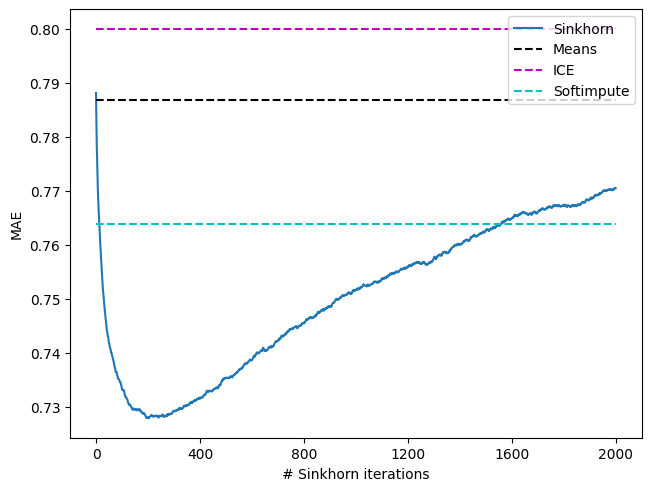

In [87]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

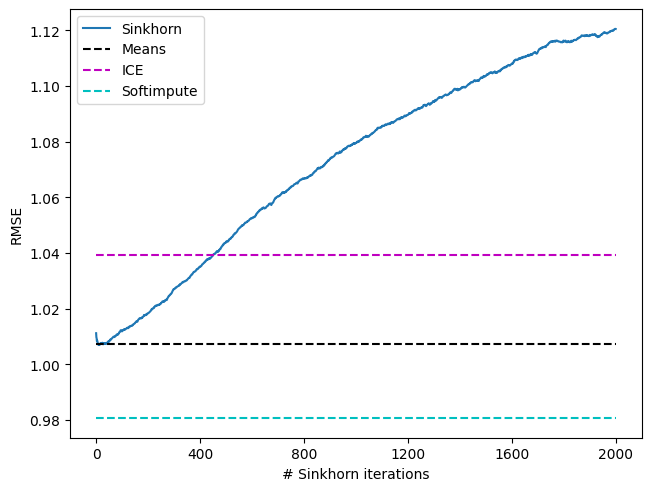

In [88]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

90% MCAR

In [89]:
#sinkhorn
n_mcar90, d_mcar90 = data_mcar90.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar90 = pick_epsilon(data_mcar90)

print(epsilon_mcar90)

sk_imputer_mcar90 = SinkhornImputation(eps=epsilon_mcar90, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar90, sk_maes90mcar, sk_rmses90mcar = sk_imputer_mcar90.fit_transform(data_mcar90, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar90_numpy = sk_imp_mcar90.detach().cpu().numpy()

sk_mae_mcar90 = MAE(sk_imp_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
sk_rmse_mcar90 = RMSE(sk_imp_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(sk_mae_mcar90,sk_rmse_mcar90)

INFO:root:batchsize = 128, epsilon = 0.1859
INFO:root:Iteration 0:	 Loss: 2.3654	 Validation MAE: 0.7933	RMSE: 1.0198


0.18586036720852495


INFO:root:Iteration 500:	 Loss: 1.5302	 Validation MAE: 0.7524	RMSE: 1.0667
INFO:root:Iteration 1000:	 Loss: 1.4307	 Validation MAE: 0.7647	RMSE: 1.1030
INFO:root:Iteration 1500:	 Loss: 1.9144	 Validation MAE: 0.7747	RMSE: 1.1239


0.7828838754815707 1.1345328111592397


In [90]:
#mean
#using numpy version of data
mean_imp_mcar90 = SimpleImputer().fit_transform(data_mcar90_numpy)
mean_mae_mcar90 = MAE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
mean_rmse_mcar90= RMSE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(mean_mae_mcar90, mean_rmse_mcar90)

#ICE
ice_imp_mcar90 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar90_numpy)
ice_mae_mcar90 = MAE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
ice_rmse_mcar90 = RMSE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(ice_mae_mcar90,ice_rmse_mcar90)

#SoftImpute
cv_error_mcar90, grid_lambda_mcar90 = cv_softimpute(data_mcar90_numpy, grid_len=15)
lbda_mcar90 = grid_lambda_mcar90[np.argmin(cv_error_mcar90)]
soft_imp_mcar90 = softimpute((data_mcar90_numpy), lbda_mcar90)[1]

soft_mae_mcar90 = MAE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
soft_rmse_mcar90 = RMSE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(soft_mae_mcar90,soft_rmse_mcar90)

0.7894572926921494 1.0150887709915453


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.8410872075956112 1.1066906006890882
0.782422459243335 0.9995889254288105


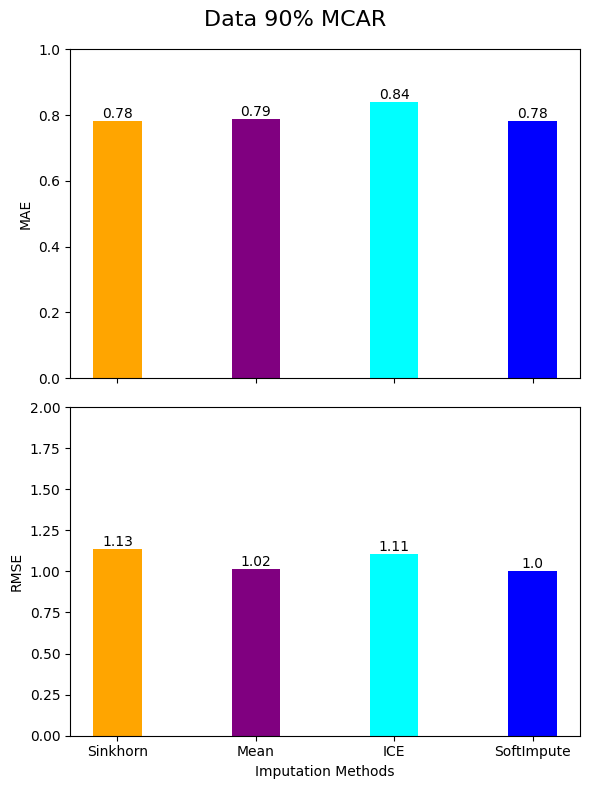

In [91]:

# Define values and categories
values_mae_mcar90 = [sk_mae_mcar90, mean_mae_mcar90, ice_mae_mcar90, soft_mae_mcar90]
values_rmse_mcar90 = [sk_rmse_mcar90, mean_rmse_mcar90, ice_rmse_mcar90, soft_rmse_mcar90]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 90% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar90, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar90, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


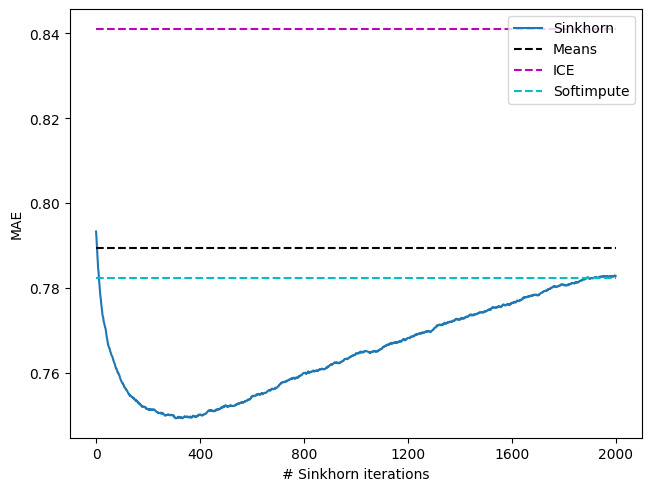

In [92]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

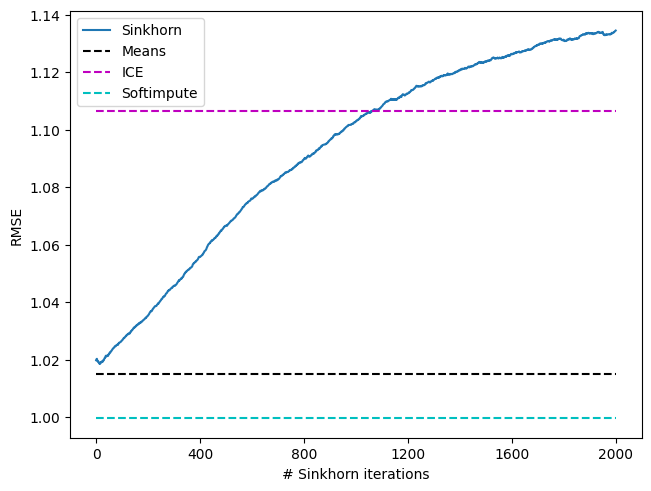

In [93]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

95% MCAR

In [94]:
#sinkhorn
n_mcar95, d_mcar95 = data_mcar95.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar95 = pick_epsilon(data_mcar95)

print(epsilon_mcar95)

sk_imputer_mcar95 = SinkhornImputation(eps=epsilon_mcar95, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar95, sk_maes95mcar, sk_rmses95mcar = sk_imputer_mcar95.fit_transform(data_mcar95, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar95_numpy = sk_imp_mcar95.detach().cpu().numpy()

sk_mae_mcar95 = MAE(sk_imp_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
sk_rmse_mcar95 = RMSE(sk_imp_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(sk_mae_mcar95,sk_rmse_mcar95)

INFO:root:batchsize = 128, epsilon = 0.0790
INFO:root:Iteration 0:	 Loss: 1.2978	 Validation MAE: 0.8011	RMSE: 1.0341


0.07899370000027373


INFO:root:Iteration 500:	 Loss: 0.6000	 Validation MAE: 0.7789	RMSE: 1.0864
INFO:root:Iteration 1000:	 Loss: 0.5898	 Validation MAE: 0.8066	RMSE: 1.1567
INFO:root:Iteration 1500:	 Loss: 0.8205	 Validation MAE: 0.8285	RMSE: 1.1946


0.8397268145673674 1.2114946062340304


In [95]:
#mean
#using numpy version of data
mean_imp_mcar95 = SimpleImputer().fit_transform(data_mcar95_numpy)
mean_mae_mcar95 = MAE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
mean_rmse_mcar95 = RMSE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(mean_mae_mcar95, mean_rmse_mcar95)

#ICE
ice_imp_mcar95 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar95_numpy)
ice_mae_mcar95 = MAE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
ice_rmse_mcar95 = RMSE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(ice_mae_mcar95,ice_rmse_mcar95)

#SoftImpute
cv_error_mcar95, grid_lambda_mcar95 = cv_softimpute(data_mcar95_numpy, grid_len=15)
lbda_mcar95 = grid_lambda_mcar95[np.argmin(cv_error_mcar95)]
soft_imp_mcar95 = softimpute((data_mcar95_numpy), lbda_mcar95)[1]

soft_mae_mcar95 = MAE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
soft_rmse_mcar95 = RMSE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(soft_mae_mcar95,soft_rmse_mcar95)

0.7944010941138925 1.0276811924675668


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.8997923164028945 1.2040839458615555
0.7849143836645875 1.0000389490423054


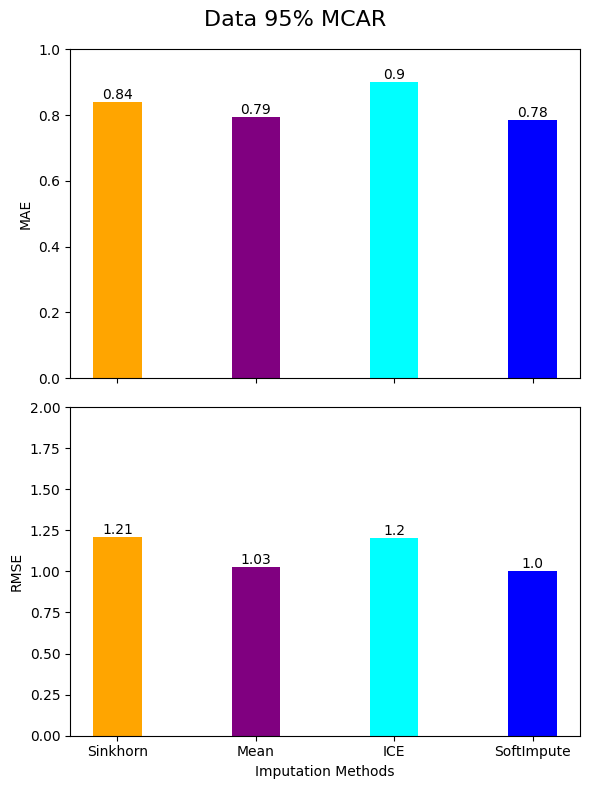

In [96]:

# Define values and categories
values_mae_mcar95 = [sk_mae_mcar95, mean_mae_mcar95, ice_mae_mcar95, soft_mae_mcar95]
values_rmse_mcar95 = [sk_rmse_mcar95, mean_rmse_mcar95, ice_rmse_mcar95, soft_rmse_mcar95]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 95% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar95, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar95, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


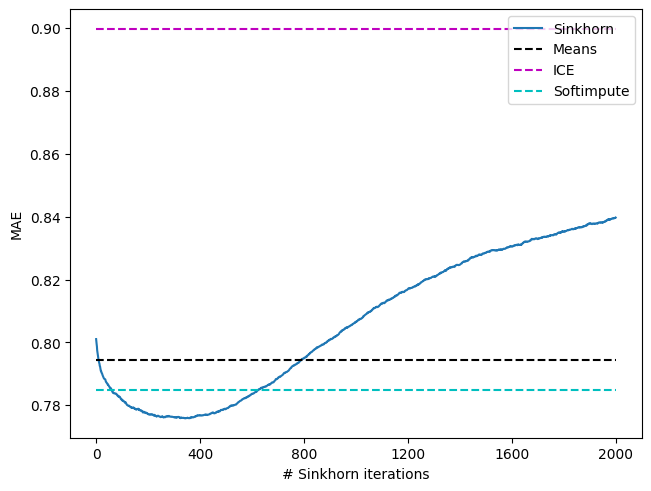

In [97]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

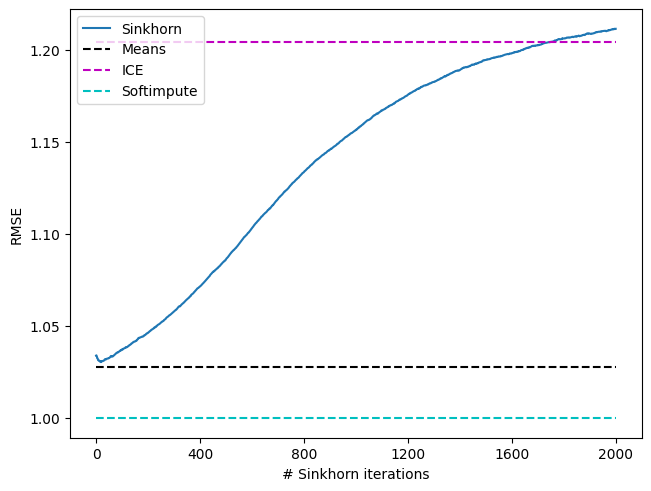

In [98]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

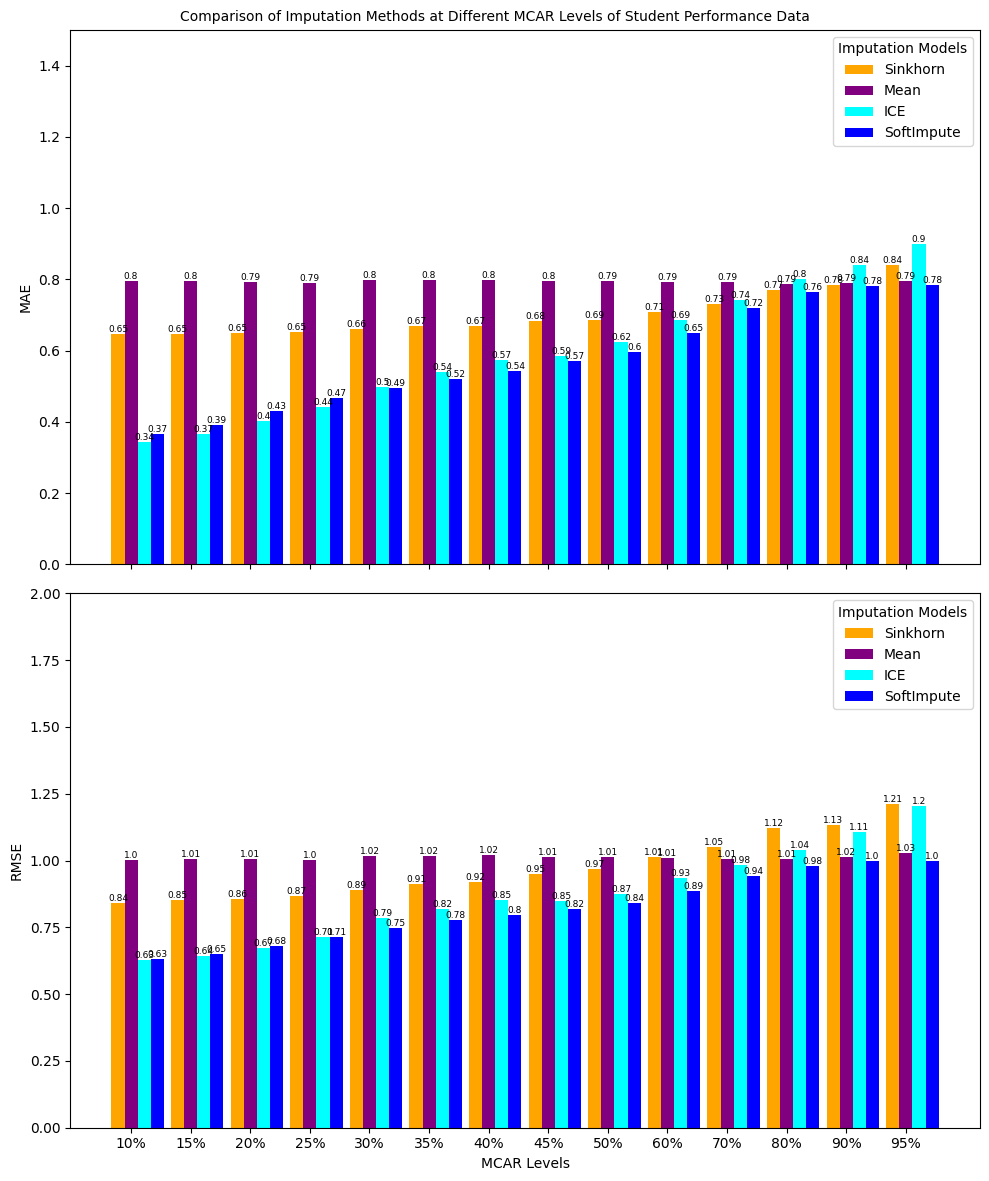

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Define your MAE and RMSE data
sk_mcar_mae = [sk_mae_mcar10, sk_mae_mcar15, sk_mae_mcar20, sk_mae_mcar25, sk_mae_mcar30,sk_mae_mcar35,sk_mae_mcar40,sk_mae_mcar45,sk_mae_mcar50,sk_mae_mcar60,sk_mae_mcar70,sk_mae_mcar80,sk_mae_mcar90,sk_mae_mcar95]
mean_mcar_mae = [mean_mae_mcar10, mean_mae_mcar15, mean_mae_mcar20, mean_mae_mcar25, mean_mae_mcar30,mean_mae_mcar35,mean_mae_mcar40,mean_mae_mcar45,mean_mae_mcar50,mean_mae_mcar60,mean_mae_mcar70,mean_mae_mcar80,mean_mae_mcar90,mean_mae_mcar95]
ice_mcar_mae = [ice_mae_mcar10, ice_mae_mcar15, ice_mae_mcar20, ice_mae_mcar25, ice_mae_mcar30,ice_mae_mcar35,ice_mae_mcar40,ice_mae_mcar45,ice_mae_mcar50,ice_mae_mcar60,ice_mae_mcar70,ice_mae_mcar80,ice_mae_mcar90,ice_mae_mcar95]
soft_mcar_mae = [soft_mae_mcar10, soft_mae_mcar15, soft_mae_mcar20, soft_mae_mcar25, soft_mae_mcar30,soft_mae_mcar35,soft_mae_mcar40,soft_mae_mcar45,soft_mae_mcar50,soft_mae_mcar60,soft_mae_mcar70,soft_mae_mcar80,soft_mae_mcar90,soft_mae_mcar95]

sk_mcar_rmse = [sk_rmse_mcar10, sk_rmse_mcar15, sk_rmse_mcar20, sk_rmse_mcar25, sk_rmse_mcar30,sk_rmse_mcar35,sk_rmse_mcar40,sk_rmse_mcar45,sk_rmse_mcar50,sk_rmse_mcar60,sk_rmse_mcar70,sk_rmse_mcar80,sk_rmse_mcar90,sk_rmse_mcar95]
mean_mcar_rmse = [mean_rmse_mcar10, mean_rmse_mcar15, mean_rmse_mcar20, mean_rmse_mcar25, mean_rmse_mcar30,mean_rmse_mcar35,mean_rmse_mcar40,mean_rmse_mcar45,mean_rmse_mcar50,mean_rmse_mcar60,mean_rmse_mcar70,mean_rmse_mcar80,mean_rmse_mcar90,mean_rmse_mcar95]
ice_mcar_rmse = [ice_rmse_mcar10, ice_rmse_mcar15, ice_rmse_mcar20, ice_rmse_mcar25, ice_rmse_mcar30,ice_rmse_mcar35,ice_rmse_mcar40,ice_rmse_mcar45,ice_rmse_mcar50,ice_rmse_mcar60,ice_rmse_mcar70,ice_rmse_mcar80,ice_rmse_mcar90,ice_rmse_mcar95]
soft_mcar_rmse = [soft_rmse_mcar10, soft_rmse_mcar15, soft_rmse_mcar20, soft_rmse_mcar25, soft_rmse_mcar30,soft_rmse_mcar35,soft_rmse_mcar40,soft_rmse_mcar45,soft_rmse_mcar50,soft_rmse_mcar60,soft_rmse_mcar70,soft_rmse_mcar80,soft_rmse_mcar90,soft_rmse_mcar95]

# Combine the MAE and RMSE data for each MCAR level
values_mae = [sk_mcar_mae, mean_mcar_mae, ice_mcar_mae, soft_mcar_mae]
values_rmse = [sk_mcar_rmse, mean_mcar_rmse, ice_mcar_rmse, soft_mcar_rmse]

# Define categories, x-axis labels, and colors
categories = ['10%', '15%', '20%', '25%', '30%','35%','40%','45%','50%','60%','70%','80%','90%','95%']
colors = ['orange', 'purple', 'cyan', 'blue']  # Yellow for Sinkhorn, purple for Mean, cyan for ICE, blue for SoftImpute
imputation_models = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
num_methods = len(categories)
bar_width = 0.22  # Width of each bar
x = np.arange(num_methods)  # X locations for the methods

# Create subplots for MAE and RMSE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Comparison of Imputation Methods at Different MCAR Levels of Student Performance Data', fontsize=10)

# Plot MAE bars for each MCAR level with custom colors
for i, (mcar, mae_values, color) in enumerate(zip(imputation_models, values_mae, colors)):
    ax1.bar(x + i * bar_width, mae_values, bar_width, label=mcar, color=color)

# Customize MAE plot
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1.5)  # Adjust based on your data
ax1.set_xticks(x + bar_width)  # Center x-ticks
ax1.set_xticklabels(categories)
ax1.legend(title="Imputation Models")

# Add values on top of MAE bars
for i, mae_values in enumerate(values_mae):
    for j, value in enumerate(mae_values):
        ax1.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Plot RMSE bars for each MCAR level with custom colors
for i, (mcar, rmse_values, color) in enumerate(zip(imputation_models, values_rmse, colors)):
    ax2.bar(x + i * bar_width, rmse_values, bar_width, label=mcar, color=color)

# Customize RMSE plot
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
ax2.set_xticks(x + bar_width)  # Center x-ticks
ax2.set_xticklabels(categories)
ax2.legend(title="Imputation Models")

# Add values on top of RMSE bars
for i, rmse_values in enumerate(values_rmse):
    for j, value in enumerate(rmse_values):
        ax2.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Show the plot
plt.xlabel('MCAR Levels')
plt.tight_layout()
plt.show()
